In [1]:

import numpy as np
import wandb
from keras.datasets import fashion_mnist, mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

In [2]:

(X,y),(X_test,y_test)=fashion_mnist.load_data()  ##Load data

X.shape ## X and X_test to be reshaped to (60000, (28x28)) array 

num_features=784        ## 784 features
num_classes=np.max(y)+1 ## 10 classes

# Reshaping the training and test feature data 
X=np.reshape(X,(X.shape[0],784))
X_test=np.reshape(X_test,(X_test.shape[0],784))

# Normalize the pixel intensities
X=X/255
X_test=X_test/255

X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,random_state=42)  ## Splitting the training data to 90% training and 10% Validation data

### One hot encode the Class_labels (y_val & y_test & y_train)
def one_hot_encode(labels):
    z=np.zeros((10,len(labels)))
    for i in range(0,len(labels)):
        z[labels[i],i]=1  
    return z

y_val_encoded=one_hot_encode(y_val)
y_train_encoded=one_hot_encode(y_train)
y_test_encoded=one_hot_encode(y_test)

#####

X=X.T
X_test=X_test.T
X_val=X_val.T
X_train=X_train.T

#####

## Number of samples in training, validation and test set

no_sample_train=X_train.shape[1]
no_sample_val=X_val.shape[1]
no_sample_test=X_test.shape[1]

In [3]:
def sigmoid(a):
    return 1./(1.+np.exp(-a))

def sigmoid_derivative(a):
    return sigmoid(a)*(1-sigmoid(a))

def tanh(a):
    return np.tanh(a)

def tanh_derivative(a):
    return (1-np.power(tanh(a),2))

def relu(a):
    return np.maximum(0,a)

def relu_derivative(a):
    return 1*(a>0)

def identity(a):
    return a

def identity_derivative(a):
    return np.ones((np.shape(a)))

def softmax(a):
  #----
  ## a => np.array 
  #----
    return np.exp(a-np.max(a,axis=0))/(np.sum(np.exp(a-np.max(a,axis=0)),axis=0))  
  ## To prevent overflow error, the numpy array has been subtracted from the maximum value in that numpy array

def derivative_softmax(a,batch_size,num_classes):
    grad_softmax = np.zeros((num_classes, num_classes,batch_size)) # This is designed only for softmax derivative at the final layer
    output=softmax(a)
    for i in range(batch_size):
        diag_output = np.diag(output[:,i])
        grad_softmax[ :, :,i] = diag_output - np.outer(output[:,i], output[:,i])   # interaction_terms in jacobian 
        grad_softmax[np.arange(num_classes), np.arange(num_classes),i] = output[ :,i] * (1 - output[:,i]) # self-interaction terms
    return grad_softmax


In [4]:
def loss_compute(y_true,y_hat,loss,batch_size,lambda_val,parameters,total_layers):

    if loss=='cross_entropy':
        J=(-1*np.sum(np.multiply(y_true,np.log2(y_hat))))/batch_size
     
    elif loss=='mse':
        J=((1/2)*(np.sum(np.power((y_true-y_hat),2))))/batch_size

  # L2 Regularisation
    sum_square_weight=0
    total_layers=total_layers
    for layer in range(1,total_layers):
        sum_square_weight+=np.sum(np.power(parameters['W_'+str(layer)],2))
  
    J+=(lambda_val/(2*batch_size))*sum_square_weight
  
    return J
    

In [5]:
class NeuralNetwork():
    def __init__(self,num_layers,activation_function,loss,batch_size,lambda_val):
        self.num_layers=num_layers
        self.num_hidden_layers=self.num_layers-2
        self.activation_function=activation_function
        self.loss=loss
        self.batch_size=batch_size
        self.lambda_val=lambda_val
      
    def weight_bias_initialize(self,neurons_per_layer,init):
        '''Initialise weights, biases, previous updates & look ahead parameters for different gradient descent algorithms

        Parameters
        ----
        neurons_per_layer: list
          list of number of neurons per layer in the structure [input_features,hiddenunits ,hiddenunits,..outputclasses]

        init: string
          initialisation type: default set to 'Xavier'

        Returns
        ----
        parameters: dictionary
          contains weights and biases. 

        old_parameters: dictionary
          previous updates initialisation. Used in nesterov, momemtum gradient descent

        look_ahead_parameters: dictionary
          copy of parameters, later used in nesterov gradient descent
        
        v: dictionary
          copy of old_parameters, later used in rmsprop, adam & nadam

        m: dictionary
          copy of old_parameters, later used in adam & nadam 

    '''

  # neurons_per_layer is a list specifying number of neurons per layer
        self.neurons_per_layer=neurons_per_layer
        self.init=init
        np.random.seed(42)

        self.parameters={}
        self.old_parameters={} ## For different kinds of gradient descent

        for i in range(1,len(self.neurons_per_layer)):
            if self.init=='Xavier':
                self.sdev=np.sqrt(2/(self.neurons_per_layer[i-1]+self.neurons_per_layer[i]))
                self.parameters['W_'+str(i)]=np.random.randn(self.neurons_per_layer[i],self.neurons_per_layer[i-1])*self.sdev
    
            if init=='random': # Random normal
                self.parameters['W_'+str(i)]=np.random.randn(self.neurons_per_layer[i],self.neurons_per_layer[i-1])*0.01

    
            self.parameters['b_'+str(i)]=np.zeros((self.neurons_per_layer[i],1))
  
            self.old_parameters['W_'+str(i)]=np.zeros((self.neurons_per_layer[i],self.neurons_per_layer[i-1]))
            self.old_parameters['b_'+str(i)]=np.zeros((self.neurons_per_layer[i],1))
  
        # For nesterov, adam, rmsprop, nadam
        self.look_ahead_parameters=self.parameters.copy()  
        self.v=self.old_parameters.copy()
        self.m=self.old_parameters.copy()           

        return self.parameters,self.old_parameters,self.look_ahead_parameters,self.v,self.m
    
    
    def forward_propagation(self,data,parameters):
        
        self.parameters=parameters
        self.data=data
        self.activation = {} # activations
        self.pre_activation = {} # pre-activations
    
        self.activation["H_0"] = self.data # H_1=training data
    
        for layer in range(1, self.num_layers):   # start from hidden layer 
            self.Weight = self.parameters["W_"+str(layer)]
            self.bias = self.parameters["b_"+str(layer)]
        
            self.pre_activation["A_"+str(layer)] = np.matmul(self.Weight,self.activation["H_"+str(layer-1)]) + self.bias    # a_i=W*h_(i-1) + b_i
        
            if layer == self.num_layers-1:
                self.activation["H_"+str(layer)] = softmax(self.pre_activation["A_"+str(layer)])  ## Output layet
            else:
                if self.activation_function == 'sigmoid':
                    self.activation["H_"+str(layer)] = sigmoid(self.pre_activation["A_"+str(layer)]) # h_i=g(a_i), g is the activation function
                elif self.activation_function == 'relu':
                    self.activation["H_"+str(layer)] = relu(self.pre_activation["A_"+str(layer)])
                elif self.activation_function == 'tanh':
                    self.activation["H_"+str(layer)] = tanh(self.pre_activation["A_"+str(layer)])
                elif self.activation_function== 'identity':
                    self.activation["H_"+str(layer)] = identity(self.pre_activation["A_"+str(layer)])

            #####
            # Can add other activation functions here
            #####
                
        self.y_pred = self.activation["H_"+str(self.num_layers-1)]  # output

        return self.y_pred,self.activation,self.pre_activation
    
    def backpropagate(self,y_hat,y_true,activation,pre_activation,parameters):  
        '''Function to calculate gradients

    Parameters
    ----------
    y_hat: np array
        output from forward propagation
    y_true: np array
        actual class labels
     
    activation: np array
        after-activations

    pre_activation: np array
        pre-activations   

    parameters: dict
        contains Weight and bias   

    activation_function: string
        activation function to be used except the output layer

    batch_size: int

    loss: string
        loss function: 'cross_entropy'/'mse'

    lamb: float
        L2 regularisation parameter: lambda

    Returns
    -------
    parameter_gradient: dict
        gradients wrt weight and biase

    '''

        self.layers_no_input=self.num_layers-1   ## No. of layers in NN exluding the input
        self.gradient_dA={}      ##Store Gradients wrt to pre-activations
        self.gradient_dH={}      ##Store Gradients wrt to after-activations
        self.parameter_gradient={}  ##Store gradients wrt to weight and bias
        self.y_true=y_true
        self.y_hat=y_hat
        self.pre_activation=pre_activation
        self.activation=activation
        self.parameters=parameters

  # Last_layer
        if self.loss=='cross_entropy':
            self.gradient_dA['dA_'+str(self.layers_no_input)]=-1*(self.y_true-self.y_hat)
  
        elif self.loss=='mse':
          self.gradient_dA['dA_'+str(self.layers_no_input)]=np.einsum('ik,ijk->jk',(self.y_hat-self.y_true),derivative_softmax(self.pre_activation["A_"+str(self.layers_no_input)],self.batch_size,num_classes))
    
  
        for layer in range(self.layers_no_input,0,-1):  # move from Hidden layer L-1 to Hidden layer 1
            self.parameter_gradient['dW_'+str(layer)]=(np.dot(self.gradient_dA['dA_'+str(layer)],self.activation["H_"+str(layer-1)].T)+self.lambda_val*self.parameters['W_'+str(layer)])/self.batch_size
            self.parameter_gradient['db_'+str(layer)]=np.sum(self.gradient_dA['dA_'+str(layer)],axis=1,keepdims=True)/self.batch_size  
    ### For batch_size I found this online
    ### Reference:https://datascience.stackexchange.com/questions/20139/gradients-for-bias-terms-in-backpropagation
    
            if layer>1:  
                if self.activation_function=='sigmoid':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*sigmoid_derivative(self.pre_activation["A_"+str(layer-1)])
    
                elif self.activation_function=='relu':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*relu_derivative(self.pre_activation["A_"+str(layer-1)])  

                elif self.activation_function=='tanh':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*tanh_derivative(self.pre_activation["A_"+str(layer-1)])   

                elif self.activation_function=='identity':
                    self.gradient_dH['dH_'+str(layer-1)]=np.matmul(self.parameters['W_'+str(layer)].T,self.gradient_dA['dA_'+str(layer)])
                    self.gradient_dA['dA_'+str(layer-1)]=self.gradient_dH['dH_'+str(layer-1)]*identity_derivative(self.pre_activation["A_"+str(layer-1)])        

        return self.parameter_gradient



   #### Just for trial

    def predict(self,data, parameters):
        self.data=data
        self.parameters=parameters
        
        self.output, _, _ = self.forward_propagation(self.data, self.parameters)
        self.predictions = np.argmax(self.output, axis=0)
        return self.predictions

    def accuracy(self,data,labels,parameters):
        self.data=data
        self.labels=labels
        self.parameters=parameters
        self.predictions = self.predict(self.data,self.parameters)
    
        self.accuracy_val=accuracy_score(self.labels,self.predictions)*100

        print(f"Accuracy = {self.accuracy_val} %")
        

        return self.predictions
   
    def loss_plot(self,train_loss,val_loss):
        self.train_loss=train_loss
        self.val_loss=val_loss
        plt.plot(list(range(0,len(self.train_loss))), self.train_loss, 'r', label="Training loss")
        plt.plot(list(range(0,len(self.val_loss))), self.val_loss, 'b', label="Validation loss")
        plt.title("Loss vs Epochs", size=10)
        plt.xlabel("Epochs", size=10)
        plt.ylabel("Loss", size=10)
        plt.legend()
        plt.show()

In [6]:

class NN_optimizers:
    def __init__(self,parameters,gradients,learning_rate,old_parameters,look_ahead_parameters,v,m,t,num_layers):
        self.parameters=parameters
        self.learning_rate=learning_rate
        self.old_parameters=old_parameters
        self.look_ahead_parameters=look_ahead_parameters
        self.gradients=gradients
        self.v=v
        self.m=m
        self.t=t
        self.num_layers=num_layers  

    def sgd(self):
    

        for i in range(1,self.num_layers): ## Since dictionary has keys 'W_1' to 'W_L'

            self.parameters['W_'+str(i)]=self.parameters['W_'+str(i)]-self.learning_rate*self.gradients['dW_'+str(i)]
            self.parameters['b_'+str(i)]=self.parameters['b_'+str(i)]-self.learning_rate*self.gradients['db_'+str(i)]
  
        return self.parameters
  
    def momentum_gd(self):
        self.beta=0.9
    

        for i in range(1,self.num_layers):
            self.old_parameters['W_'+str(i)]=self.beta*self.old_parameters['W_'+str(i)]+self.gradients['dW_'+str(i)]
            self.parameters['W_'+str(i)]-=self.learning_rate*self.old_parameters['W_'+str(i)]

            self.old_parameters['b_'+str(i)]=self.beta*self.old_parameters['b_'+str(i)]+self.gradients['db_'+str(i)]
            self.parameters['b_'+str(i)]-=self.learning_rate*self.old_parameters['b_'+str(i)]
  

        return self.parameters,self.old_parameters

  
   
    def nesterov_gd(self): # Rewritten NAG
        self.beta=0.9
    
        for layer in range(1,self.num_layers):
            self.old_parameters['W_'+str(layer)]=self.beta*self.old_parameters['W_'+str(layer)]+self.gradients['dW_'+str(layer)]
            self.parameters['W_'+str(layer)]=self.parameters['W_'+str(layer)]-self.learning_rate*(self.beta*self.old_parameters['W_'+str(layer)]+self.gradients['dW_'+str(layer)])

            self.old_parameters['b_'+str(layer)]=self.beta*self.old_parameters['b_'+str(layer)]+self.gradients['db_'+str(layer)]
            self.parameters['b_'+str(layer)]=self.parameters['b_'+str(layer)]-self.learning_rate*(self.beta*self.old_parameters['b_'+str(layer)]+self.gradients['db_'+str(layer)])
       
        return self.parameters, self.old_parameters
  
    def rmsprop(self):
        self.beta=0.9
        self.epsilon=1e-7

        for i in range(1,self.num_layers):

            v_dw=self.beta*self.v['W_'+str(i)]+(1-self.beta)*np.power(self.gradients['dW_'+str(i)],2)
            v_db=self.beta*self.v['b_'+str(i)]+(1-self.beta)*np.power(self.gradients['db_'+str(i)],2)


            self.v['W_'+str(i)]=v_dw
            self.v['b_'+str(i)]=v_db

            self.parameters['W_'+str(i)]-=((self.learning_rate/np.sqrt(v_dw+self.epsilon))*self.gradients['dW_'+str(i)])
            self.parameters['b_'+str(i)]-=((self.learning_rate/np.sqrt(v_db+self.epsilon))*self.gradients['db_'+str(i)])
        return self.parameters, self.v
  

    def adam(self):

        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8

        for layers in range(1, self.num_layers):
            m_dw = self.beta1*self.m["W_"+str(layers)] + (1-self.beta1)*self.gradients["dW_"+str(layers)]
            v_dw = self.beta2*self.v["W_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["dW_"+str(layers)],2)
            mw_hat = m_dw/(1.0 - self.beta1**self.t)
            vw_hat = v_dw/(1.0 - self.beta2**self.t)
            self.parameters["W_"+str(layers)] -= (self.learning_rate * mw_hat)/(np.sqrt(vw_hat + self.epsilon))

            m_db = self.beta1*self.m["b_"+str(layers)] + (1-self.beta1)*self.gradients["db_"+str(layers)]
            v_db = self.beta2*self.v["b_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["db_"+str(layers)],2)
            mb_hat = m_db/(1.0 - self.beta1**self.t)
            vb_hat = v_db/(1.0 - self.beta2**self.t)

            self.parameters["b_"+str(layers)] -= (self.learning_rate * mb_hat)/(np.sqrt(vb_hat + self.epsilon))

            self.v["W_"+str(layers)] = v_dw
            self.m["W_"+str(layers)] = m_dw
            self.v["b_"+str(layers)] = v_db
            self.m["b_"+str(layers)] = m_db

        self.t = self.t + 1  # timestep
        return self.parameters, self.v, self.m, self.t
    
    def nadam(self):
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8 # 1e-8 while running sweep
    
        for layers in range(1, self.num_layers):
            m_dw = self.beta1*self.m["W_"+str(layers)] + (1-self.beta1)*self.gradients["dW_"+str(layers)]
            v_dw = self.beta2*self.v["W_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["dW_"+str(layers)],2)
            mw_hat = m_dw/(1.0 - self.beta1**self.t)
            vw_hat = v_dw/(1.0 - self.beta2**self.t)

            self.weight_adapt=self.beta1*mw_hat + (((1-self.beta1)*self.gradients["dW_"+str(layers)])/(1-self.beta1**self.t))
            self.parameters["W_"+str(layers)] -= ((self.learning_rate)/(np.sqrt(vw_hat) + self.epsilon))*self.weight_adapt
 
            self.v["W_"+str(layers)] = v_dw
            self.m["W_"+str(layers)] = m_dw

            m_db = self.beta1*self.m["b_"+str(layers)] + (1-self.beta1)*self.gradients["db_"+str(layers)]
            v_db = self.beta2*self.v["b_"+str(layers)] + (1-self.beta2)*np.power(self.gradients["db_"+str(layers)],2)
            mb_hat = m_db/(1.0 - self.beta1**self.t)
            vb_hat = v_db/(1.0 - self.beta2**self.t)
            
            self.bias_adapt=self.beta1*mb_hat + (((1-self.beta1)*self.gradients["db_"+str(layers)])/(1-self.beta1**self.t))
            self.parameters["b_"+str(layers)] -= ((self.learning_rate)/(np.sqrt(vb_hat) + self.epsilon))*self.bias_adapt

            self.v["b_"+str(layers)] = v_db
            self.m["b_"+str(layers)] = m_db

        self.t = self.t + 1  # timestep


        return self.parameters, self.v, self.m, self.t

In [7]:
def early_stopping(val_loss,best_loss,best_epoch,patience,parameters,count):
    global patience_count
    global best_params
    if val_loss<best_loss:
        best_loss=val_loss
        best_epoch=count
        patience_count=0
        best_params=parameters.copy()
    else:
        patience_count+=1
  
    if patience_count >= patience:
        print(f"Stopping early at epoch {count}. Best epoch: {best_epoch}")
        return True, best_loss, best_epoch, best_params
    else:
        return False, best_loss, best_epoch, best_params

In [ ]:
L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov

In [15]:

def NN_fit(train_data,train_labels,val_data,val_labels):
        train_data=train_data
        train_labels=train_labels
        val_data=val_data
        val_labels=val_labels
        NN=NeuralNetwork(num_layers=3,activation_function='identity',loss="mse",batch_size=64,lambda_val=0.5)

        neurons_per_layer = [num_features] + [32]*NN.num_hidden_layers + [num_classes]
        parameters, old_parameters,look_ahead_parameters,v,m = NN.weight_bias_initialize(neurons_per_layer,init="Xavier") # initialize the parameters and past updates matrices
        
        check=parameters.copy()
        optimizer='adam'

        patience_count=0
  
        epoch_cost = []
        validation_epoch_cost = []
        epochs=10
        count = 1
        learning_rate=0.001
        t=1
        patience=4
        best_loss=np.inf
        best_epoch=0

        while count<=epochs:
            remaining_data=train_data.shape[1] % NN.batch_size

            for i in range(0, train_data.shape[1], NN.batch_size):
                
                if train_data.shape[1]-i==remaining_data:
                    NN.batch_size=remaining_data
                output,H,A = NN.forward_propagation(train_data[:,i:i+NN.batch_size],parameters)
                gradients = NN.backpropagate(output,train_labels[:,i:i+NN.batch_size],H,A,parameters)
                optim=NN_optimizers(parameters,gradients,learning_rate,old_parameters,look_ahead_parameters,v,m,t,NN.num_layers)
                
                if optimizer=='sgd':
                    parameters=optim.sgd()
                if optimizer == 'nesterov':
                    parameters,old_parameters,look_ahead_parameters=optim.nesterov_gd()
                if optimizer=='adam':
                    parameters,v,m,t=optim.adam()
                if optimizer == 'rmsprop':
                    parameters,v =optim.rmsprop()
                elif optimizer == 'momentum':
                    parameters,old_parameters = optim.momentum_gd()
                elif optimizer == 'nadam':
                    parameters,v,m,t=optim.nadam()
              

        # loss for the full training set
            full_output, _, _ = NN.forward_propagation(train_data, parameters)
            cost = loss_compute(train_labels, full_output, NN.loss,no_sample_train, NN.lambda_val, parameters,NN.num_layers)
            epoch_cost.append(cost)
        
        # loss for the validation set
            out_val, _, _ = NN.forward_propagation(val_data, parameters)
            val_cost = loss_compute(val_labels, out_val,NN.loss,no_sample_val, NN.lambda_val, parameters,NN.num_layers)
            validation_epoch_cost.append(val_cost)
            
            stop, best_loss, best_epoch, best_parameters = early_stopping(val_cost, best_loss, best_epoch,patience,parameters,count)
            count = count + 1
            
        # Training accuracy at the end of the epoch
            train_predictions = NN.predict(train_data, parameters)
            train_acc = accuracy_score(y_train, train_predictions)
           
        # Validation accuracy at the end of the epoch
            val_predictions = NN.predict(val_data, parameters)
            val_acc = accuracy_score(y_val, val_predictions)
            if stop:
                break
        return epoch_cost,validation_epoch_cost,train_acc,val_acc,val_predictions

In [16]:
cost,val,acc,va,po=NN_fit(X_train,y_train_encoded,X_val,y_val_encoded)

Stopping early at epoch 5. Best epoch: 1


In [17]:
cost

[0.15390079688876293,
 0.16587174009803465,
 0.1665780581599844,
 0.16688439447523842,
 0.16684694348662213]

In [9]:
## Neural Netowrk for for Wandb sweep

def NN_wandb_sweep():
    """
    This function is used for the hyperparameter tuning using wandb sweeps
    """
    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_function': 'relu',
        'optimizer': 'adam',
        'init': 'Xavier',
        'lambda_val': 0,
        'neurons_per_layer': 64,
        'num_hidden_layers': 3
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    neurons_per_layer = config.neurons_per_layer
    num_hidden_layers = config.num_hidden_layers
    init = config.init
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_function = config.activation_function
    lambda_val = config.lambda_val
    optimizer = config.optimizer
    
    loss='mse'
    # Display the hyperparameters
    run_name = f"nn_{neurons_per_layer}_nh_{num_hidden_layers}_af_{activation_function}_lr_{learning_rate}_init_{init}_optim_{optimizer}_batch_{batch_size}_l2_{lambda_val}_epochs_{epochs}"
    print(run_name)

    # Neural Network
    NN=NeuralNetwork(num_layers=num_hidden_layers+2,activation_function=activation_function,loss=loss,batch_size=batch_size,lambda_val=lambda_val)

    #Layer sizes
    neurons_layer_wise = [num_features] + [neurons_per_layer]*NN.num_hidden_layers + [num_classes]

    parameters, old_parameters,look_ahead_parameters, v, m = NN.weight_bias_initialize(neurons_layer_wise,init=init) # initialize the parameters and past updates matrices
    
    train_epoch_cost = []
    validation_epoch_cost = []
    
    patience_count=0  # For early stopping
    patience=5
    best_loss=np.inf
    best_epoch=0

    
    count=1
    t=1
    
    while count<=epochs:
        remaining_data=X_train.shape[1] % NN.batch_size
        for i in range(0, X_train.shape[1], NN.batch_size):
            if X_train.shape[1]-i==remaining_data:
                NN.batch_size=remaining_data        
            output,H,A = NN.forward_propagation(X_train[:,i:i+NN.batch_size],parameters)
            gradients = NN.backpropagate(output,y_train_encoded[:,i:i+NN.batch_size],H,A,parameters)
            optim=NN_optimizers(parameters,gradients,learning_rate,old_parameters,look_ahead_parameters,v,m,t,NN.num_layers)
            if optimizer=='sgd':
                parameters=optim.sgd()
            if optimizer == 'nesterov':
                parameters,old_parameters=optim.nesterov_gd()
            if optimizer=='adam':
                parameters,v,m,t=optim.adam()
            if optimizer == 'rmsprop':
                parameters,v =optim.rmsprop()
            if optimizer == 'momentum':
                parameters,old_parameters = optim.momentum_gd()
            if optimizer == 'nadam':
                parameters,v,m,t=optim.nadam()

        # loss for the full training set
        full_output, _, _ = NN.forward_propagation(X_train, parameters)
        train_cost = loss_compute(y_train_encoded, full_output, NN.loss,no_sample_train, NN.lambda_val, parameters,NN.num_layers)
        train_epoch_cost.append(train_cost)
        
        # loss for the validation set
        out_val, _, _ = NN.forward_propagation(X_val, parameters)
        val_cost = loss_compute(y_val_encoded, out_val,NN.loss,no_sample_val, NN.lambda_val, parameters,NN.num_layers)
        validation_epoch_cost.append(val_cost)

        # Training accuracy at the end of the epoch
        train_predictions = NN.predict(X_train, parameters)
        train_acc = accuracy_score(y_train, train_predictions)

        # Validation accuracy at the end of the epoch
        val_predictions = NN.predict(X_val, parameters)
        val_acc = accuracy_score(y_val, val_predictions)
        
        stop, best_loss, best_epoch, best_parameters = early_stopping(val_cost, best_loss, best_epoch,patience,parameters,count)
        count = count + 1
        
        wandb.log({"training_acc": train_acc, "validation_accuracy": val_acc, "training_loss": train_cost, "validation loss": val_cost, 'epoch': count-1})

        
        
        if stop:
            break
    # Plot the training and validation cost curves
    NN.loss_plot(train_epoch_cost, validation_epoch_cost)

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()


    
    return parameters, train_epoch_cost

Create sweep with ID: ubmffrxb
Sweep URL: https://wandb.ai/shashwat_mm19b053/Assignment-1/sweeps/ubmffrxb


wandb: Agent Starting Run: sy8hmc1s with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: mm19b053 (shashwat_mm19b053). Use `wandb login --relogin` to force relogin


nn_128_nh_4_af_sigmoid_lr_0.0001_init_Xavier_optim_rmsprop_batch_128_l2_0_epochs_5


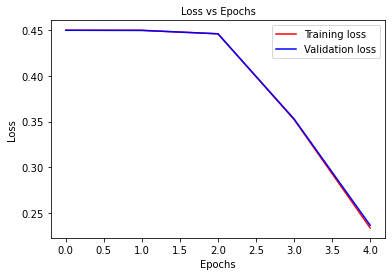

wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


epoch,▁▃▅▆█
training_acc,▁▁▄▅█
training_loss,███▅▁
validation loss,███▅▁
validation_accuracy,▁▁▄▅█
epoch,5
training_acc,0.67757
training_loss,0.23364
validation loss,0.23655
validation_accuracy,0.66817


wandb: Agent Starting Run: wa4sppfh with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


nn_128_nh_6_af_tanh_lr_0.001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_15


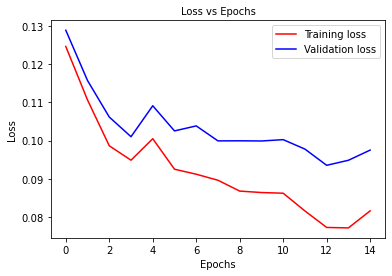

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▃▅▅▅▆▆▆▇▇▇▇██▇
training_loss,█▆▄▄▄▃▃▃▂▂▂▂▁▁▂
validation loss,█▅▄▂▄▃▃▂▂▂▂▂▁▁▂
validation_accuracy,▁▄▅▆▅▆▆▇▇▇▇███▇
epoch,15
training_acc,0.89146
training_loss,0.08166
validation loss,0.09753
validation_accuracy,0.86983


wandb: Agent Starting Run: gh81edoc with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_32_nh_4_af_identity_lr_0.01_init_Xavier_optim_sgd_batch_128_l2_0_epochs_40


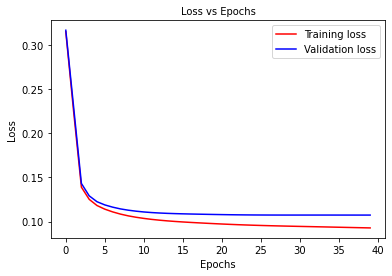

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▄▇▇▇▇▇▇████████████████████████████████
training_loss,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▇▇▇███████████████████████████████████
epoch,40
training_acc,0.87689
training_loss,0.09274
validation loss,0.1073
validation_accuracy,0.855


wandb: Agent Starting Run: o2e0i51d with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: sgd


nn_128_nh_6_af_sigmoid_lr_0.0001_init_Xavier_optim_sgd_batch_256_l2_0_epochs_40


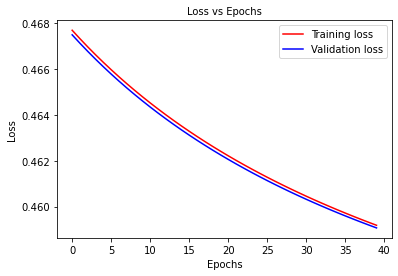

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
validation loss,██▇▇▇▇▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
training_acc,0.10024
training_loss,0.45918
validation loss,0.45907
validation_accuracy,0.09783


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dmsawrsr with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov


nn_128_nh_4_af_identity_lr_0.001_init_Xavier_optim_nesterov_batch_128_l2_0_epochs_5


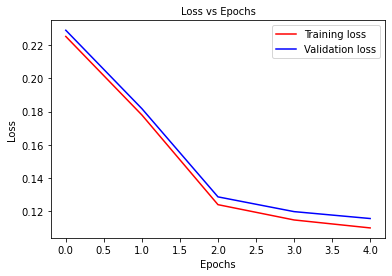

epoch,▁▃▅▆█
training_acc,▁▅▇██
training_loss,█▅▂▁▁
validation loss,█▅▂▁▁
validation_accuracy,▁▅▇██
epoch,5
training_acc,0.8502
training_loss,0.11004
validation loss,0.11568
validation_accuracy,0.83783


wandb: Agent Starting Run: qxh4w21w with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


nn_256_nh_5_af_sigmoid_lr_0.0001_init_random_optim_adam_batch_128_l2_0_epochs_5


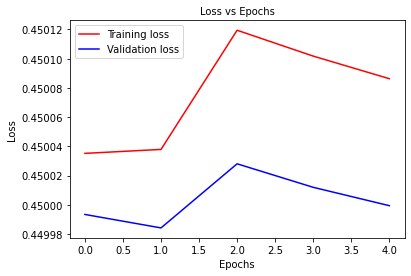

epoch,▁▃▅▆█
training_acc,▁▁███
training_loss,▁▁█▇▅
validation loss,▂▁█▅▃
validation_accuracy,██▁▁▁
epoch,5
training_acc,0.09965
training_loss,0.45009
validation loss,0.45
validation_accuracy,0.10317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pncuvgmg with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


nn_256_nh_3_af_tanh_lr_0.01_init_Xavier_optim_nesterov_batch_64_l2_0_epochs_30
Stopping early at epoch 27. Best epoch: 22


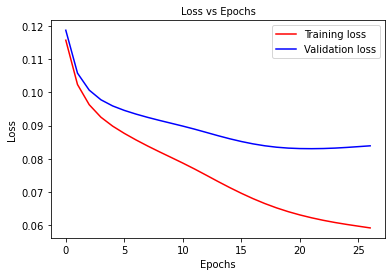

epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇██
training_acc,▁▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████
training_loss,█▆▆▅▅▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
validation loss,█▅▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▄▅▅▅▅▆▆▆▆▇▇▇▇▇███████████
epoch,27
training_acc,0.92239
training_loss,0.05922
validation loss,0.08391
validation_accuracy,0.8865


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: erakqv83 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


nn_128_nh_3_af_relu_lr_0.01_init_Xavier_optim_sgd_batch_32_l2_0_epochs_15


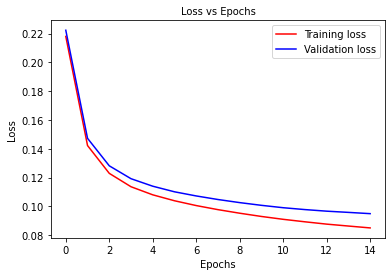

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▅▆▇▇▇▇▇███████
training_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁
validation loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇▇████████
epoch,15
training_acc,0.88583
training_loss,0.08503
validation loss,0.09493
validation_accuracy,0.8695


wandb: Agent Starting Run: gxdx4k2i with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: sgd


nn_128_nh_6_af_tanh_lr_0.01_init_Xavier_optim_sgd_batch_128_l2_0_epochs_20


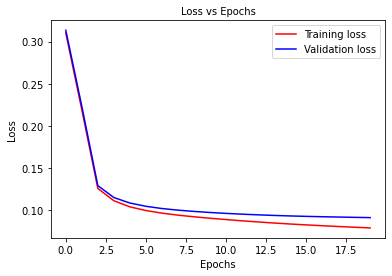

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▃▆▇▇▇▇▇████████████
training_loss,█▅▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▇▇▇███████████████
epoch,20
training_acc,0.89398
training_loss,0.07899
validation loss,0.09121
validation_accuracy,0.87317


wandb: Agent Starting Run: ww8jbjdb with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


nn_64_nh_3_af_tanh_lr_0.01_init_random_optim_nesterov_batch_64_l2_0_epochs_15


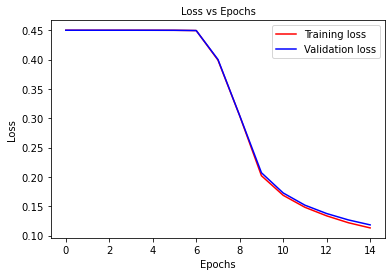

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▁▁▁▁▁▂▂▅▇▇▇███
training_loss,███████▇▅▃▂▂▁▁▁
validation loss,███████▇▅▃▂▂▁▁▁
validation_accuracy,▁▁▁▁▁▁▂▂▅▇▇▇███
epoch,15
training_acc,0.84793
training_loss,0.11305
validation loss,0.11821
validation_accuracy,0.83733


wandb: Agent Starting Run: 51q1aefg with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam


nn_32_nh_4_af_identity_lr_0.001_init_Xavier_optim_adam_batch_32_l2_0_epochs_15
Stopping early at epoch 7. Best epoch: 2


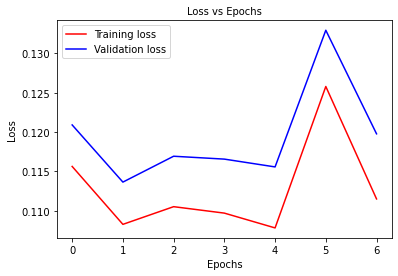

epoch,▁▂▃▅▆▇█
training_acc,▅▇▇▇█▁▇
training_loss,▄▁▂▂▁█▂
validation loss,▄▁▂▂▂█▃
validation_accuracy,▅█▆▆▇▁▆
epoch,7
training_acc,0.8508
training_loss,0.11152
validation loss,0.11978
validation_accuracy,0.8385


wandb: Agent Starting Run: g20enf4d with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_64_nh_3_af_identity_lr_0.001_init_random_optim_nadam_batch_256_l2_0_epochs_30
Stopping early at epoch 26. Best epoch: 21


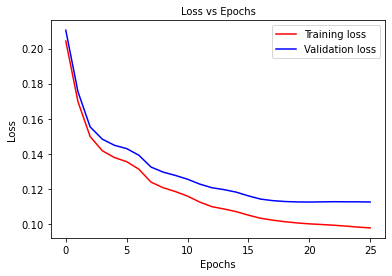

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
training_acc,▁▃▅▅▅▆▆▆▆▇▇▇▇▇▇▇██████████
training_loss,█▆▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▆▆▇▇▇▇▇▇▇████████████
epoch,26
training_acc,0.87048
training_loss,0.09784
validation loss,0.1126
validation_accuracy,0.84683


wandb: Agent Starting Run: ndik46is with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_32_nh_5_af_identity_lr_0.01_init_Xavier_optim_nadam_batch_64_l2_0_epochs_5


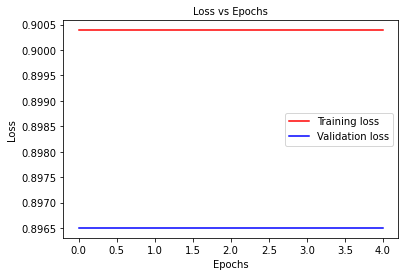

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation loss,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09961
training_loss,0.90039
validation loss,0.8965
validation_accuracy,0.1035


wandb: Agent Starting Run: dns0l74p with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: sgd


nn_32_nh_6_af_tanh_lr_0.0001_init_random_optim_sgd_batch_64_l2_0_epochs_5


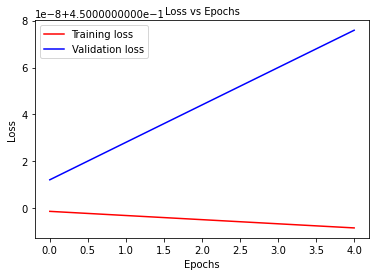

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation loss,▁▁▅▅█
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: mvpwj1mx with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


nn_128_nh_6_af_identity_lr_0.001_init_random_optim_rmsprop_batch_64_l2_0_epochs_15
Stopping early at epoch 7. Best epoch: 2


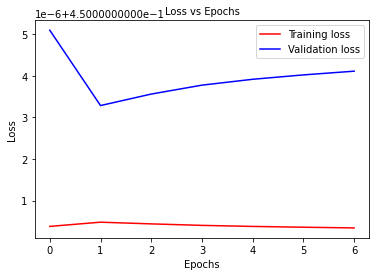

epoch,▁▂▃▅▆▇█
training_acc,▁██████
training_loss,▃█▆▅▃▁▁
validation loss,█▁▂▃▃▄▄
validation_accuracy,█▁▁▁▁▁▁
epoch,7
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Agent Starting Run: wl0oeng3 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


nn_64_nh_5_af_sigmoid_lr_0.01_init_Xavier_optim_sgd_batch_256_l2_0_epochs_15


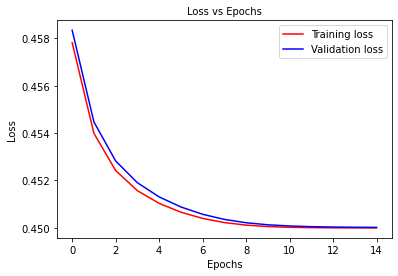

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▁▁▁▁▁█████████
training_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁
validation loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,██████▁▁▁▁▁▁▁▁▁
epoch,15
training_acc,0.10093
training_loss,0.45
validation loss,0.45002
validation_accuracy,0.09167


wandb: Agent Starting Run: 81k2bgpw with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov


nn_32_nh_4_af_relu_lr_0.01_init_random_optim_nesterov_batch_128_l2_0_epochs_30
Stopping early at epoch 15. Best epoch: 10


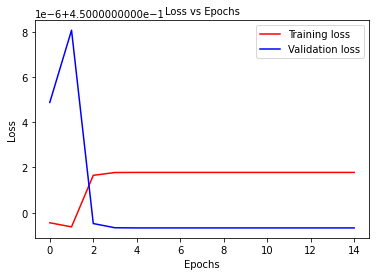

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,██▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▂▁█████████████
validation loss,▅█▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁█████████████
epoch,15
training_acc,0.09961
training_loss,0.45
validation loss,0.45
validation_accuracy,0.1035


wandb: Agent Starting Run: a9uxubed with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


nn_256_nh_5_af_relu_lr_0.001_init_random_optim_sgd_batch_64_l2_0_epochs_30
Stopping early at epoch 6. Best epoch: 1


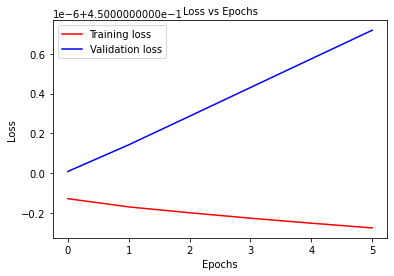

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▇▅▄▂▁
validation loss,▁▂▄▅▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Agent Starting Run: q1habe3j with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


nn_32_nh_3_af_identity_lr_0.0001_init_Xavier_optim_sgd_batch_64_l2_0_epochs_20


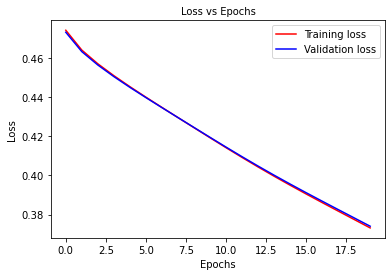

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▆▇▇██
training_loss,█▇▇▆▆▆▅▅▅▄▄▃▃▃▃▂▂▂▁▁
validation loss,█▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▁▁
validation_accuracy,▁▁▂▂▂▃▃▄▄▄▅▅▅▅▆▆▇▇██
epoch,20
training_acc,0.46822
training_loss,0.37316
validation loss,0.37402
validation_accuracy,0.46333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tmvxs9tw with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


nn_256_nh_4_af_sigmoid_lr_0.001_init_Xavier_optim_nadam_batch_32_l2_0_epochs_5


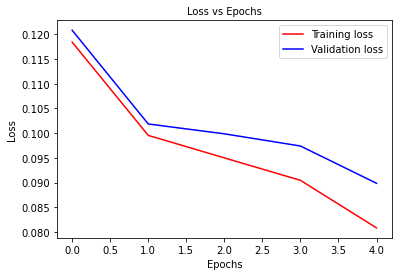

epoch,▁▃▅▆█
training_acc,▁▅▅▆█
training_loss,█▄▄▃▁
validation loss,█▄▃▃▁
validation_accuracy,▁▆▆▆█
epoch,5
training_acc,0.88974
training_loss,0.08083
validation loss,0.08986
validation_accuracy,0.87583


wandb: Agent Starting Run: h9d4vu9k with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


nn_256_nh_6_af_identity_lr_0.0001_init_random_optim_adam_batch_256_l2_0_epochs_20
Stopping early at epoch 6. Best epoch: 1


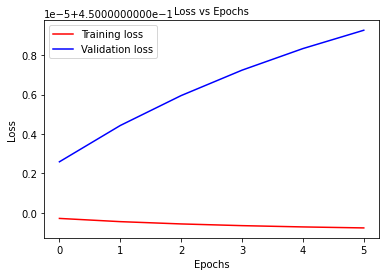

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▄▃▁▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: m4fu8ivq with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


nn_32_nh_4_af_identity_lr_0.0001_init_random_optim_nadam_batch_128_l2_0_epochs_5


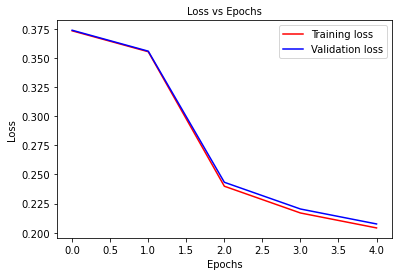

epoch,▁▃▅▆█
training_acc,▁▂▇██
training_loss,█▇▂▂▁
validation loss,█▇▃▂▁
validation_accuracy,▁▂▇██
epoch,5
training_acc,0.70333
training_loss,0.20409
validation loss,0.2075
validation_accuracy,0.69467


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qr27rn6d with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_128_nh_5_af_relu_lr_0.01_init_random_optim_nadam_batch_128_l2_0_epochs_30
Stopping early at epoch 7. Best epoch: 2


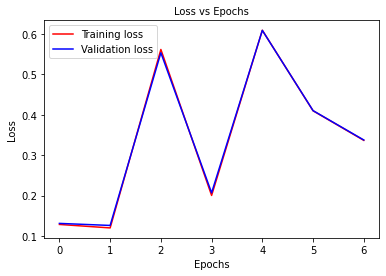

epoch,▁▂▃▅▆▇█
training_acc,██▄▇▁▃▃
training_loss,▁▁▇▂█▅▄
validation loss,▁▁▇▂█▅▄
validation_accuracy,██▄▇▁▃▃
epoch,7
training_acc,0.39489
training_loss,0.33673
validation loss,0.33768
validation_accuracy,0.39083


wandb: Agent Starting Run: fdulobun with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_256_nh_3_af_relu_lr_0.01_init_Xavier_optim_rmsprop_batch_256_l2_0_epochs_5


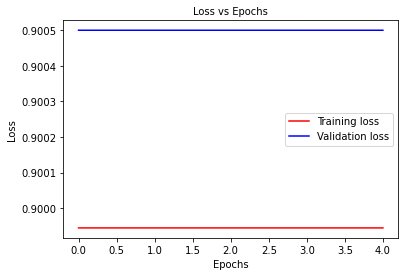

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁▁▁▁▁
validation loss,▁▁▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10006
training_loss,0.89994
validation loss,0.9005
validation_accuracy,0.0995


wandb: Agent Starting Run: wwqquh0y with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_32_nh_4_af_sigmoid_lr_0.001_init_random_optim_rmsprop_batch_256_l2_0_epochs_5


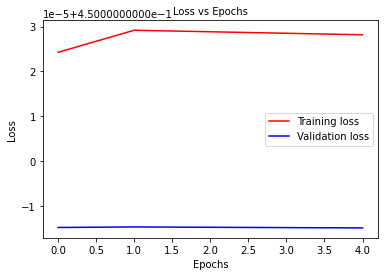

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁██▇▇
validation loss,▄█▅▃▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09965
training_loss,0.45003
validation loss,0.44999
validation_accuracy,0.10317


wandb: Agent Starting Run: v8tze2xk with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov


nn_32_nh_4_af_tanh_lr_0.01_init_Xavier_optim_nesterov_batch_256_l2_0_epochs_40


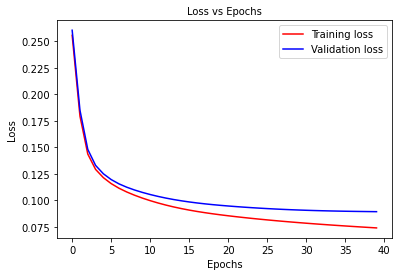

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
training_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▇▇▇▇▇▇▇▇▇███████████████████████████
epoch,40
training_acc,0.90167
training_loss,0.07402
validation loss,0.08933
validation_accuracy,0.8775


wandb: Agent Starting Run: 8m5r689d with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


nn_32_nh_5_af_tanh_lr_0.01_init_Xavier_optim_sgd_batch_128_l2_0_epochs_30


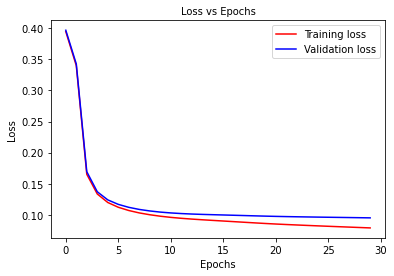

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▃▆▇▇▇▇▇██████████████████████
training_loss,█▇▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▇▇▇█████████████████████████
epoch,30
training_acc,0.89441
training_loss,0.07909
validation loss,0.09524
validation_accuracy,0.86883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tihs4bez with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


nn_32_nh_6_af_identity_lr_0.001_init_Xavier_optim_adam_batch_64_l2_0_epochs_5


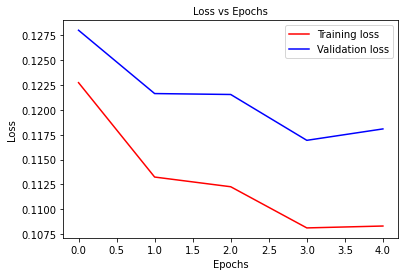

epoch,▁▃▅▆█
training_acc,▁▆▆██
training_loss,█▃▃▁▁
validation loss,█▄▄▁▂
validation_accuracy,▁▄▆█▇
epoch,5
training_acc,0.85431
training_loss,0.1083
validation loss,0.11809
validation_accuracy,0.8395


wandb: Agent Starting Run: vazw9gdn with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_256_nh_5_af_sigmoid_lr_0.001_init_Xavier_optim_nadam_batch_128_l2_0_epochs_5


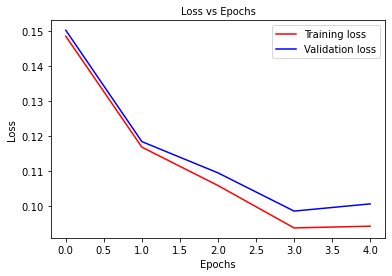

epoch,▁▃▅▆█
training_acc,▁▅▇██
training_loss,█▄▃▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▆▇██
epoch,5
training_acc,0.87333
training_loss,0.09439
validation loss,0.10074
validation_accuracy,0.86367


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 82hbcesn with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


nn_256_nh_6_af_relu_lr_0.001_init_Xavier_optim_momentum_batch_256_l2_0_epochs_5


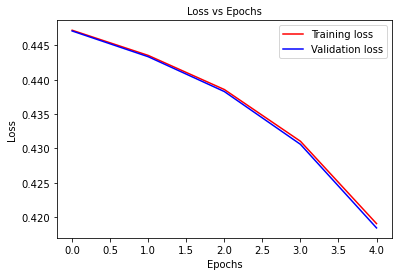

epoch,▁▃▅▆█
training_acc,▁▁▂▄█
training_loss,█▇▆▄▁
validation loss,█▇▆▄▁
validation_accuracy,▁▁▂▄█
epoch,5
training_acc,0.40233
training_loss,0.41906
validation loss,0.41843
validation_accuracy,0.40967


wandb: Agent Starting Run: xhkbepx3 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


nn_64_nh_6_af_relu_lr_0.01_init_random_optim_momentum_batch_32_l2_0_epochs_15
Stopping early at epoch 15. Best epoch: 10


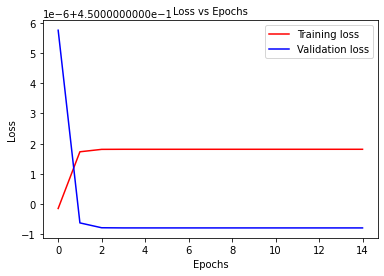

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁██████████████
validation loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁██████████████
epoch,15
training_acc,0.09961
training_loss,0.45
validation loss,0.45
validation_accuracy,0.1035


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u5yeh0x6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_128_nh_6_af_tanh_lr_0.01_init_Xavier_optim_nesterov_batch_128_l2_0_epochs_30
Stopping early at epoch 17. Best epoch: 12


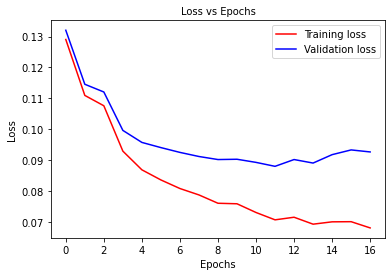

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
training_acc,▁▃▃▅▆▆▆▇▇▇▇██████
training_loss,█▆▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁
validation loss,█▅▅▃▂▂▂▂▁▁▁▁▁▁▂▂▂
validation_accuracy,▁▄▄▆▆▇▇▇▇▇█████▇▇
epoch,17
training_acc,0.91013
training_loss,0.06818
validation loss,0.09272
validation_accuracy,0.87717


wandb: Agent Starting Run: niz0lkzf with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


nn_64_nh_5_af_relu_lr_0.01_init_random_optim_rmsprop_batch_128_l2_0_epochs_40
Stopping early at epoch 6. Best epoch: 1


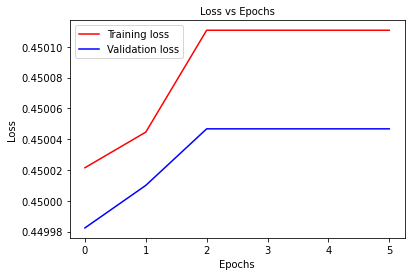

epoch,▁▂▄▅▇█
training_acc,█▁▁▁▁▁
training_loss,▁▃████
validation loss,▁▄████
validation_accuracy,▁█████
epoch,6
training_acc,0.09965
training_loss,0.45011
validation loss,0.45005
validation_accuracy,0.10317


wandb: Agent Starting Run: t3pp4yal with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nadam


nn_256_nh_6_af_relu_lr_0.0001_init_Xavier_optim_nadam_batch_64_l2_0_epochs_20
Stopping early at epoch 20. Best epoch: 15


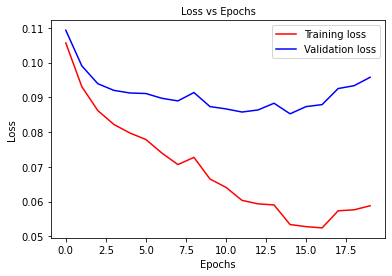

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▃▃▄▄▄▅▅▅▆▆▇▇▇███▇▇▇
training_loss,█▆▅▅▅▄▄▃▄▃▃▂▂▂▁▁▁▂▂▂
validation loss,█▅▄▃▃▃▂▂▃▂▁▁▁▂▁▂▂▃▃▄
validation_accuracy,▁▃▄▅▅▆▆▆▆▆▇██▇██▇▆▆▆
epoch,20
training_acc,0.92452
training_loss,0.05882
validation loss,0.09579
validation_accuracy,0.87883


wandb: Agent Starting Run: 546e1r3e with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_64_nh_3_af_relu_lr_0.001_init_random_optim_nadam_batch_64_l2_0_epochs_15


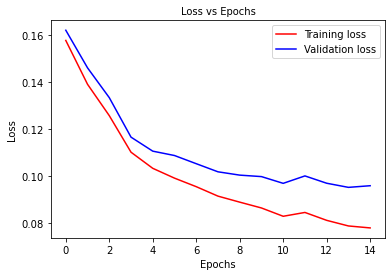

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▂▄▅▆▆▇▇▇▇█▇███
training_loss,█▆▅▄▃▃▃▂▂▂▁▂▁▁▁
validation loss,█▆▅▃▃▂▂▂▂▁▁▂▁▁▁
validation_accuracy,▁▃▄▆▆▆▇▇▇▇█▇███
epoch,15
training_acc,0.89598
training_loss,0.07792
validation loss,0.09584
validation_accuracy,0.87467


wandb: Agent Starting Run: 0ue6ijc5 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_128_nh_3_af_relu_lr_0.0001_init_random_optim_rmsprop_batch_128_l2_0_epochs_20


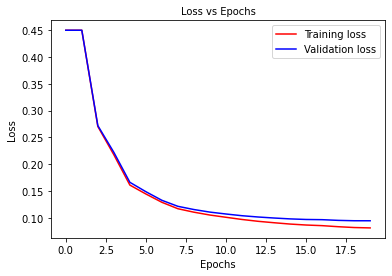

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▅▆▇▇▇█████████████
training_loss,██▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation loss,██▄▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▅▆▇▇██████████████
epoch,20
training_acc,0.89111
training_loss,0.08086
validation loss,0.09421
validation_accuracy,0.87217


wandb: Agent Starting Run: q02tyc2q with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_256_nh_5_af_identity_lr_0.001_init_Xavier_optim_nadam_batch_256_l2_0_epochs_20
Stopping early at epoch 15. Best epoch: 10


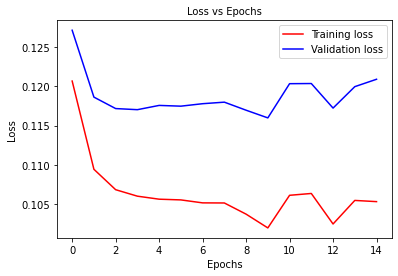

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▅▆▆▆▇▇▇▇█▇▇█▇▇
training_loss,█▄▃▃▂▂▂▂▂▁▃▃▁▂▂
validation loss,█▃▂▂▂▂▂▂▂▁▄▄▂▃▄
validation_accuracy,▁▅▆▆▅▆▆▆██▆▆█▇▆
epoch,15
training_acc,0.86157
training_loss,0.10528
validation loss,0.12091
validation_accuracy,0.84083


wandb: Agent Starting Run: 01f08g3n with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


nn_32_nh_6_af_sigmoid_lr_0.01_init_Xavier_optim_adam_batch_32_l2_0_epochs_5


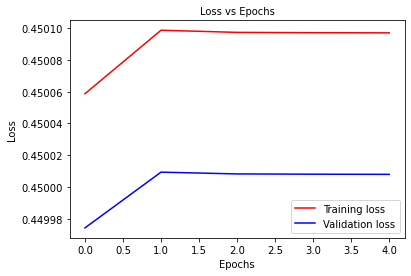

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁████
validation loss,▁████
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09965
training_loss,0.4501
validation loss,0.45001
validation_accuracy,0.10317


wandb: Agent Starting Run: jxnnd5cj with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


nn_128_nh_6_af_sigmoid_lr_0.0001_init_random_optim_rmsprop_batch_128_l2_0_epochs_15
Stopping early at epoch 6. Best epoch: 1


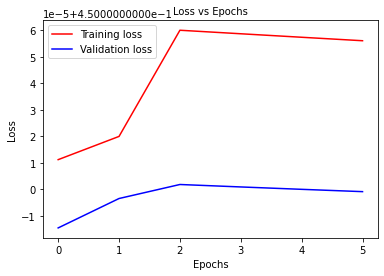

epoch,▁▂▄▅▇█
training_acc,█▁▁▁▁▁
training_loss,▁▂███▇
validation loss,▁▆██▇▇
validation_accuracy,▁█████
epoch,6
training_acc,0.09965
training_loss,0.45006
validation loss,0.45
validation_accuracy,0.10317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wpe9i7o2 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


nn_256_nh_5_af_sigmoid_lr_0.01_init_random_optim_adam_batch_256_l2_0_epochs_15
Stopping early at epoch 6. Best epoch: 1


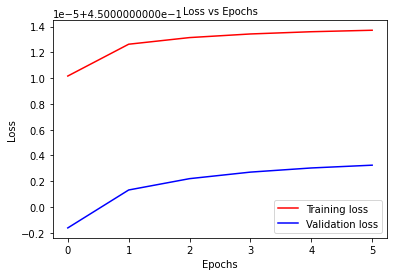

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▆▇▇██
validation loss,▁▅▆▇██
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.09961
training_loss,0.45001
validation loss,0.45
validation_accuracy,0.1035


wandb: Agent Starting Run: x0p3h35a with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum


nn_32_nh_5_af_relu_lr_0.01_init_Xavier_optim_momentum_batch_64_l2_0_epochs_20


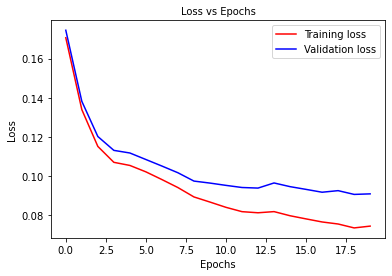

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▄▅▆▆▆▆▆▇▇▇▇▇▇██████
training_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
validation loss,█▅▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▆▆▆▇▇▇▇██████████
epoch,20
training_acc,0.89965
training_loss,0.0745
validation loss,0.09096
validation_accuracy,0.875


wandb: Agent Starting Run: z9516lut with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nadam


nn_256_nh_6_af_sigmoid_lr_0.01_init_Xavier_optim_nadam_batch_256_l2_0_epochs_5


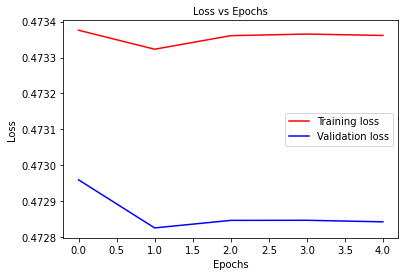

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▁▆▇▆
validation loss,█▁▂▂▂
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09965
training_loss,0.47336
validation loss,0.47284
validation_accuracy,0.10317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: do4rtg9j with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


nn_256_nh_5_af_tanh_lr_0.0001_init_random_optim_sgd_batch_256_l2_0_epochs_15
Stopping early at epoch 6. Best epoch: 1


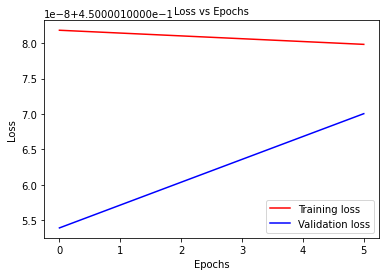

epoch,▁▂▄▅▇█
training_acc,█▇▆▄▃▁
training_loss,█▁▁▁▁▁
validation loss,▁▁▁▁▁▁
validation_accuracy,█▇▆▃▂▁
epoch,6
training_acc,0.07422
training_loss,0.45
validation loss,0.45
validation_accuracy,0.0765


wandb: Agent Starting Run: vfa18gbs with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_256_nh_3_af_sigmoid_lr_0.0001_init_Xavier_optim_nadam_batch_128_l2_0_epochs_40


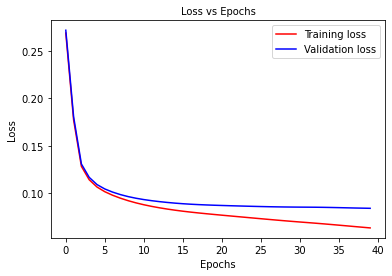

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████████
training_loss,█▅▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▇▇▇▇▇▇███████████████████████████████
epoch,40
training_acc,0.91731
training_loss,0.06362
validation loss,0.08424
validation_accuracy,0.88483


wandb: Agent Starting Run: dqa6aeax with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


nn_256_nh_3_af_relu_lr_0.0001_init_random_optim_momentum_batch_32_l2_0_epochs_15


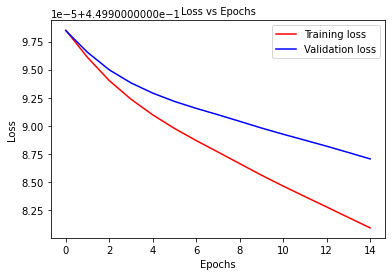

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▃█▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▆▆▅▅▄▄▃▃▂▂▂▁▁
validation loss,█▇▆▅▅▄▄▃▃▃▂▂▂▁▁
validation_accuracy,▄█▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
training_acc,0.10093
training_loss,0.44998
validation loss,0.44999
validation_accuracy,0.09167


wandb: Agent Starting Run: 9q2a5x2t with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


nn_32_nh_5_af_sigmoid_lr_0.01_init_random_optim_rmsprop_batch_32_l2_0_epochs_30
Stopping early at epoch 6. Best epoch: 1


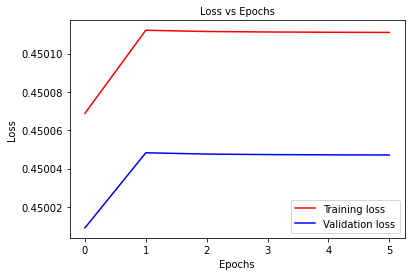

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁█████
validation loss,▁█████
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.09965
training_loss,0.45011
validation loss,0.45005
validation_accuracy,0.10317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 89pcm691 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nadam


nn_64_nh_6_af_identity_lr_0.0001_init_Xavier_optim_nadam_batch_256_l2_0_epochs_30


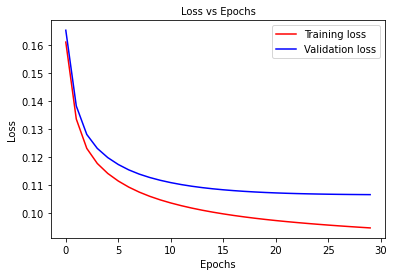

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▄▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
training_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇▇▇▇▇▇█████████████████
epoch,30
training_acc,0.87352
training_loss,0.09459
validation loss,0.10652
validation_accuracy,0.85433


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 44mnp8x6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_256_nh_5_af_sigmoid_lr_0.0001_init_random_optim_nadam_batch_64_l2_0_epochs_20


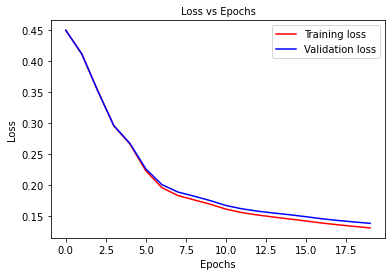

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▂▄▅▆▇▇▇▇███████████
training_loss,█▇▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation loss,█▇▆▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▂▄▅▆▇▇▇▇███████████
epoch,20
training_acc,0.8183
training_loss,0.13043
validation loss,0.1378
validation_accuracy,0.8055


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9xkdnavq with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum


nn_256_nh_5_af_tanh_lr_0.0001_init_Xavier_optim_momentum_batch_128_l2_0_epochs_15


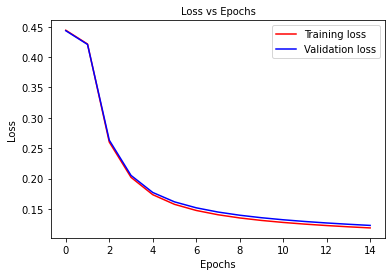

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▃▆▇▇██████████
training_loss,██▄▃▂▂▂▁▁▁▁▁▁▁▁
validation loss,██▄▃▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▆▇▇▇█████████
epoch,15
training_acc,0.83698
training_loss,0.11881
validation loss,0.12293
validation_accuracy,0.83083


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tj0l8al7 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_32_nh_3_af_tanh_lr_0.01_init_Xavier_optim_nadam_batch_64_l2_0_epochs_20
Stopping early at epoch 12. Best epoch: 7


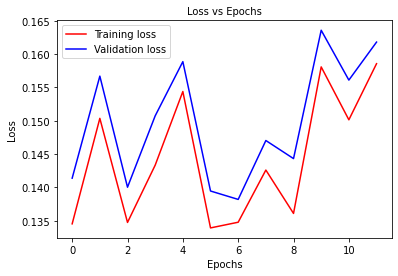

epoch,▁▂▂▃▄▄▅▅▆▇▇█
training_acc,▅▃▆▄▃█▇▅▇▁▁▁
training_loss,▁▆▁▄▇▁▁▃▂█▆█
validation loss,▂▆▂▄▇▁▁▃▃█▆█
validation_accuracy,▄▄▅▄▄██▅▆▁▁▂
epoch,12
training_acc,0.78398
training_loss,0.15856
validation loss,0.1618
validation_accuracy,0.77883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2zfvuv1f with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_256_nh_5_af_relu_lr_0.0001_init_Xavier_optim_nadam_batch_32_l2_0_epochs_20
Stopping early at epoch 13. Best epoch: 8


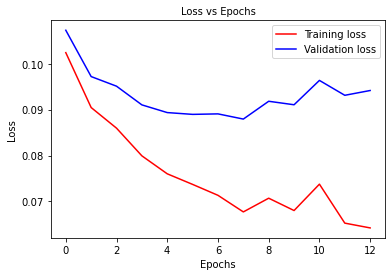

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
training_acc,▁▃▄▅▅▆▆▇▇▇▆██
training_loss,█▆▅▄▃▃▂▂▂▂▃▁▁
validation loss,█▄▄▂▂▁▁▁▂▂▄▃▃
validation_accuracy,▁▃▄▇▇▇▇█▇█▇▇█
epoch,13
training_acc,0.91619
training_loss,0.06423
validation loss,0.09417
validation_accuracy,0.88083


wandb: Agent Starting Run: 9bsa0tnq with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nesterov


nn_32_nh_4_af_relu_lr_0.0001_init_random_optim_nesterov_batch_32_l2_0_epochs_40
Stopping early at epoch 6. Best epoch: 1


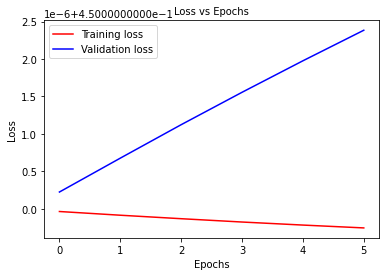

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▇▅▄▂▁
validation loss,▁▂▄▅▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Agent Starting Run: 64hpglyr with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


nn_32_nh_6_af_identity_lr_0.001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_5


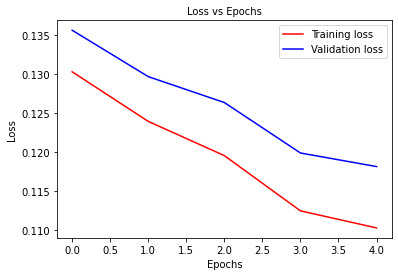

epoch,▁▃▅▆█
training_acc,▁▃▅██
training_loss,█▆▄▂▁
validation loss,█▆▄▂▁
validation_accuracy,▁▃▆██
epoch,5
training_acc,0.85019
training_loss,0.11029
validation loss,0.11814
validation_accuracy,0.84067


wandb: Agent Starting Run: v6zc78db with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_256_nh_3_af_tanh_lr_0.0001_init_random_optim_nadam_batch_128_l2_0_epochs_15


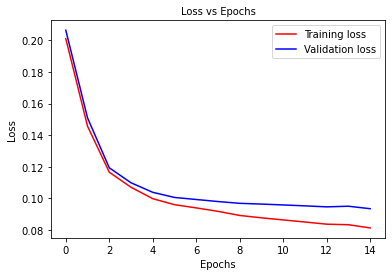

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▄▆▆▇▇▇▇███████
training_loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁
validation loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▇▇▇▇████████
epoch,15
training_acc,0.89046
training_loss,0.08125
validation loss,0.09341
validation_accuracy,0.87367


wandb: Agent Starting Run: dhytwq9b with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam


nn_64_nh_4_af_sigmoid_lr_0.0001_init_random_optim_adam_batch_32_l2_0_epochs_15
Stopping early at epoch 7. Best epoch: 2


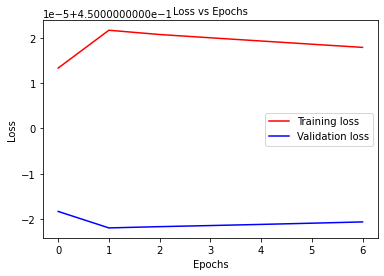

epoch,▁▂▃▅▆▇█
training_acc,▁▁▁▁▁▁▁
training_loss,▁█▇▇▆▅▅
validation loss,█▁▂▂▂▃▄
validation_accuracy,▁▁▁▁▁▁▁
epoch,7
training_acc,0.09961
training_loss,0.45002
validation loss,0.44998
validation_accuracy,0.1035


wandb: Agent Starting Run: 7dlle3dm with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: sgd


nn_128_nh_6_af_identity_lr_0.01_init_Xavier_optim_sgd_batch_32_l2_0_epochs_20


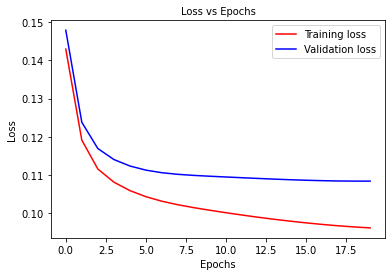

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▄▆▆▆▇▇▇▇▇▇▇████████
training_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇▇▇████████████
epoch,20
training_acc,0.87237
training_loss,0.09616
validation loss,0.10841
validation_accuracy,0.85317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 57mtmmar with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


nn_128_nh_3_af_identity_lr_0.001_init_Xavier_optim_momentum_batch_256_l2_0_epochs_20


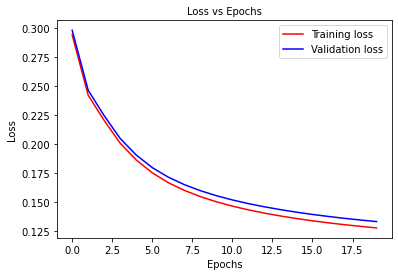

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▃▃▅▅▆▆▇▇▇▇▇████████
training_loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
validation loss,█▆▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▃▃▅▅▆▆▇▇▇▇▇████████
epoch,20
training_acc,0.82783
training_loss,0.12741
validation loss,0.13289
validation_accuracy,0.8195


wandb: Agent Starting Run: rjj0b4v9 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_64_nh_4_af_relu_lr_0.001_init_Xavier_optim_sgd_batch_64_l2_0_epochs_5


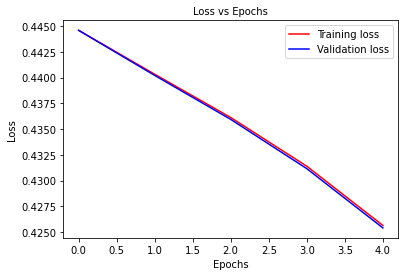

epoch,▁▃▅▆█
training_acc,▁▃▅▆█
training_loss,█▆▅▃▁
validation loss,█▆▅▃▁
validation_accuracy,▁▃▅▆█
epoch,5
training_acc,0.25919
training_loss,0.42564
validation loss,0.4254
validation_accuracy,0.26367


wandb: Agent Starting Run: vxi50ssi with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


nn_256_nh_5_af_sigmoid_lr_0.01_init_random_optim_sgd_batch_64_l2_0_epochs_5


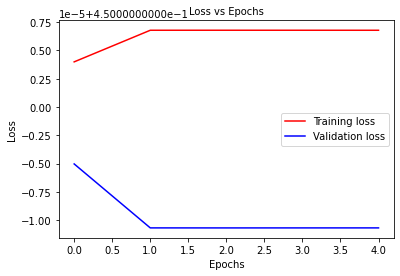

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁████
validation loss,█▁▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09985
training_loss,0.45001
validation loss,0.44999
validation_accuracy,0.10133


wandb: Agent Starting Run: aqjjyib9 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_128_nh_3_af_identity_lr_0.0001_init_random_optim_nadam_batch_64_l2_0_epochs_40


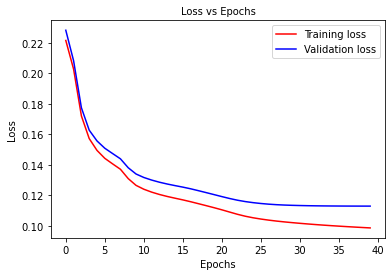

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▂▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
training_loss,█▇▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████████████
epoch,40
training_acc,0.8687
training_loss,0.09871
validation loss,0.11298
validation_accuracy,0.84667


wandb: Agent Starting Run: ty7nm93g with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


nn_32_nh_5_af_tanh_lr_0.01_init_random_optim_sgd_batch_32_l2_0_epochs_20
Stopping early at epoch 6. Best epoch: 1


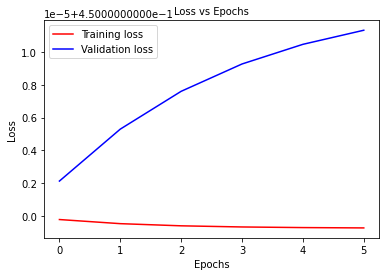

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▃▂▁▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: z97fcnc0 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_256_nh_3_af_sigmoid_lr_0.0001_init_random_optim_nadam_batch_256_l2_0_epochs_30


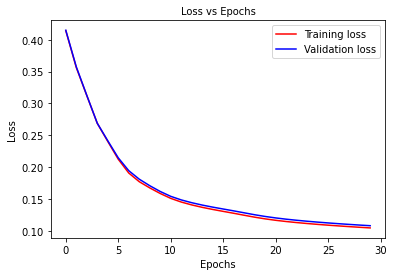

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇███████████████
training_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇██████████████
epoch,30
training_acc,0.85837
training_loss,0.10454
validation loss,0.10801
validation_accuracy,0.85333


wandb: Agent Starting Run: zzlvjf4a with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_256_nh_6_af_tanh_lr_0.01_init_random_optim_nesterov_batch_64_l2_0_epochs_15
Stopping early at epoch 6. Best epoch: 1


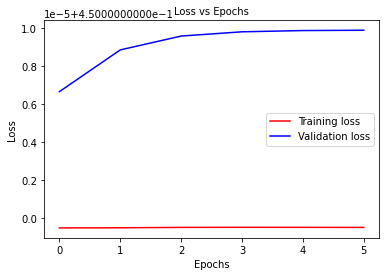

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁████
validation loss,▁▆▇███
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: 6c1yrv7n with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


nn_64_nh_5_af_relu_lr_0.0001_init_Xavier_optim_adam_batch_32_l2_0_epochs_30


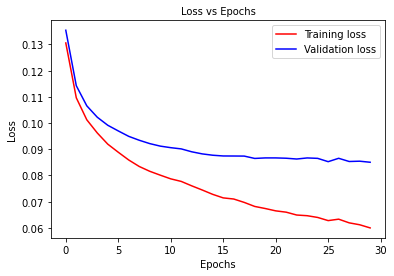

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████
training_loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
validation loss,█▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇▇█▇▇▇████████████
epoch,30
training_acc,0.92096
training_loss,0.05999
validation loss,0.08505
validation_accuracy,0.88433


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ja2cpc95 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


nn_256_nh_6_af_sigmoid_lr_0.001_init_Xavier_optim_momentum_batch_64_l2_0_epochs_30


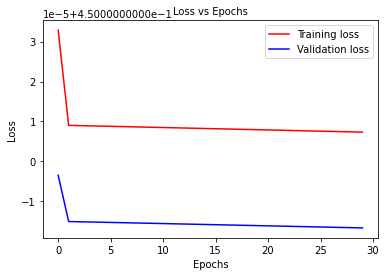

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,30
training_acc,0.09961
training_loss,0.45001
validation loss,0.44998
validation_accuracy,0.1035


wandb: Agent Starting Run: 6uve0eqi with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


nn_128_nh_3_af_relu_lr_0.0001_init_Xavier_optim_sgd_batch_32_l2_0_epochs_30


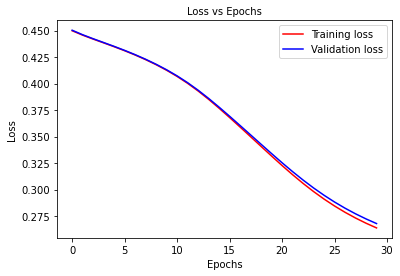

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▂▂▃▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███████
training_loss,████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
validation loss,████▇▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▂▂▃▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇███████
epoch,30
training_acc,0.65378
training_loss,0.26385
validation loss,0.26797
validation_accuracy,0.64483


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wlk0nmnu with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_128_nh_5_af_sigmoid_lr_0.001_init_random_optim_nadam_batch_256_l2_0_epochs_5


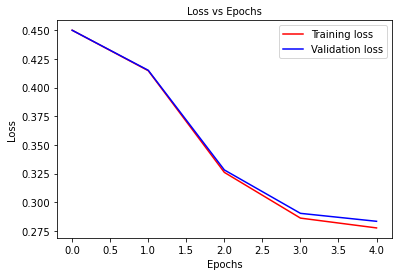

epoch,▁▃▅▆█
training_acc,▁▃▆██
training_loss,█▇▃▁▁
validation loss,█▇▃▁▁
validation_accuracy,▁▃▆██
epoch,5
training_acc,0.47422
training_loss,0.27754
validation loss,0.28332
validation_accuracy,0.464


wandb: Agent Starting Run: chs5cn0t with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_256_nh_4_af_relu_lr_0.01_init_random_optim_rmsprop_batch_64_l2_0_epochs_5


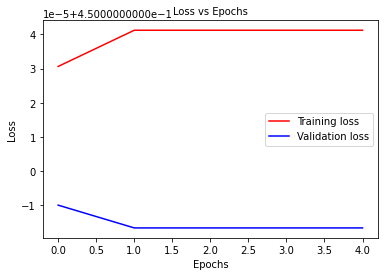

epoch,▁▃▅▆█
training_acc,█▁▁▁▁
training_loss,▁████
validation loss,█▁▁▁▁
validation_accuracy,▁████
epoch,5
training_acc,0.09965
training_loss,0.45004
validation loss,0.44998
validation_accuracy,0.10317


wandb: Agent Starting Run: 0xxc95aj with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: sgd


nn_32_nh_5_af_identity_lr_0.0001_init_random_optim_sgd_batch_128_l2_0_epochs_15
Stopping early at epoch 6. Best epoch: 1


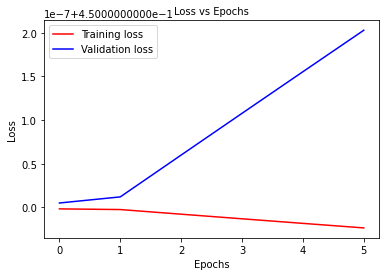

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁
validation loss,▁▁▂▅▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Agent Starting Run: f2ngivrs with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


nn_256_nh_5_af_relu_lr_0.001_init_random_optim_rmsprop_batch_128_l2_0_epochs_20
Stopping early at epoch 13. Best epoch: 8


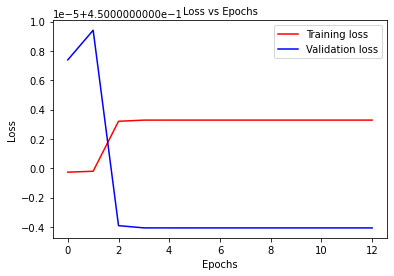

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
training_acc,██▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁███████████
validation loss,▇█▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁███████████
epoch,13
training_acc,0.09961
training_loss,0.45
validation loss,0.45
validation_accuracy,0.1035


wandb: Agent Starting Run: 14fv57yx with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_128_nh_4_af_sigmoid_lr_0.0001_init_random_optim_rmsprop_batch_64_l2_0_epochs_5


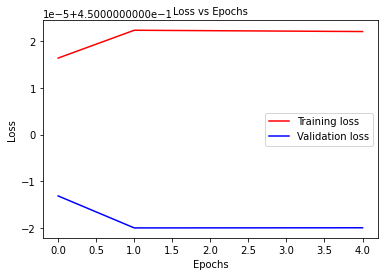

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁████
validation loss,█▁▁▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.09985
training_loss,0.45002
validation loss,0.44998
validation_accuracy,0.10133


wandb: Agent Starting Run: zivikjir with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_256_nh_4_af_sigmoid_lr_0.001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_20
Stopping early at epoch 20. Best epoch: 15


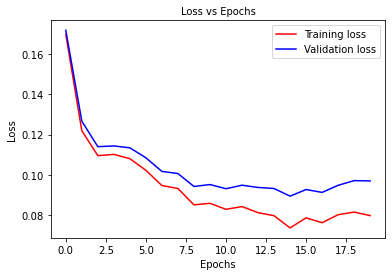

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▅▅▅▆▆▆▇▇▇▇▇▇███████
training_loss,█▅▄▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▂▁
validation loss,█▄▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▂▂
validation_accuracy,▁▅▆▆▆▆▇▇▇▇█▇██████▇█
epoch,20
training_acc,0.89676
training_loss,0.0796
validation loss,0.09689
validation_accuracy,0.87417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jui36u0p with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_32_nh_6_af_relu_lr_0.0001_init_random_optim_nesterov_batch_128_l2_0_epochs_40
Stopping early at epoch 6. Best epoch: 1


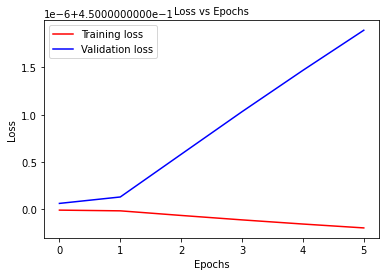

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,██▆▅▂▁
validation loss,▁▁▃▅▆█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Agent Starting Run: 4iyzr6hj with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


nn_128_nh_6_af_tanh_lr_0.01_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_20
Stopping early at epoch 10. Best epoch: 5


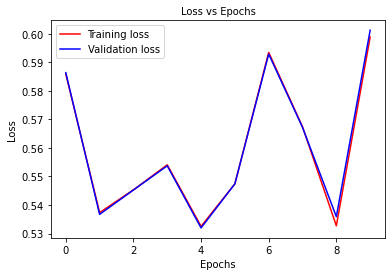

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,████▁████▂
training_loss,▇▂▂▃▁▃▇▅▁█
validation loss,▆▁▂▃▁▃▇▅▁█
validation_accuracy,▁▁▁▁█▁▁▁▁▇
epoch,10
training_acc,0.09985
training_loss,0.59883
validation loss,0.60122
validation_accuracy,0.10133


wandb: Agent Starting Run: 0ogjfwif with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


nn_256_nh_3_af_tanh_lr_0.001_init_random_optim_nesterov_batch_64_l2_0_epochs_15


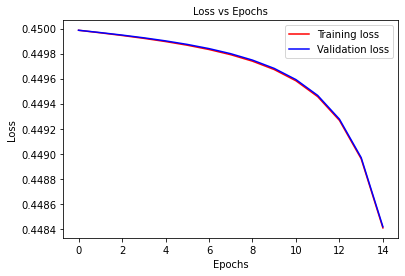

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▁▁▁▂▂▃▄▅▇███▇▆
training_loss,█████▇▇▇▇▇▆▆▅▃▁
validation loss,█████▇▇▇▇▇▆▆▅▃▁
validation_accuracy,▁▁▁▁▁▂▃▄▅▆███▇▆
epoch,15
training_acc,0.33296
training_loss,0.44841
validation loss,0.44842
validation_accuracy,0.3215


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7fek8euo with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


nn_64_nh_3_af_tanh_lr_0.001_init_Xavier_optim_momentum_batch_64_l2_0_epochs_5


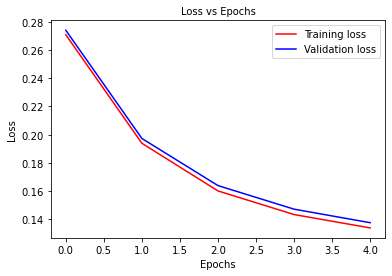

epoch,▁▃▅▆█
training_acc,▁▅▇██
training_loss,█▄▂▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▅▇██
epoch,5
training_acc,0.81917
training_loss,0.13394
validation loss,0.13763
validation_accuracy,0.81533


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bb7kokk9 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_32_nh_6_af_sigmoid_lr_0.0001_init_Xavier_optim_nesterov_batch_64_l2_0_epochs_15


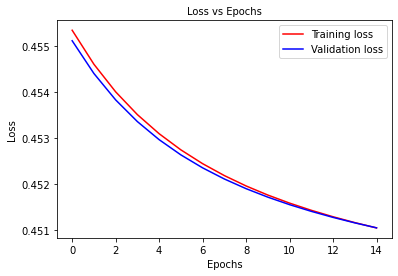

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
validation loss,█▇▆▅▄▄▃▃▂▂▂▂▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,15
training_acc,0.10019
training_loss,0.45104
validation loss,0.45104
validation_accuracy,0.09833


wandb: Agent Starting Run: t1si1k08 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_32_nh_3_af_relu_lr_0.0001_init_random_optim_rmsprop_batch_128_l2_0_epochs_20


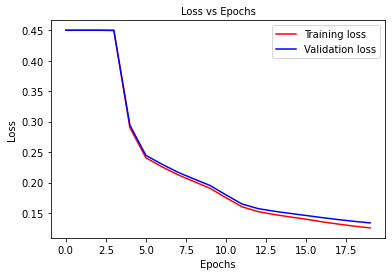

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▁▂▅▆▇▇▇▇▇▇████████
training_loss,████▅▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
validation loss,████▅▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▂▅▆▇▇▇▇▇█████████
epoch,20
training_acc,0.82969
training_loss,0.12543
validation loss,0.13363
validation_accuracy,0.81667


wandb: Agent Starting Run: s5fgodhh with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_256_nh_3_af_tanh_lr_0.001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_40
Stopping early at epoch 16. Best epoch: 11


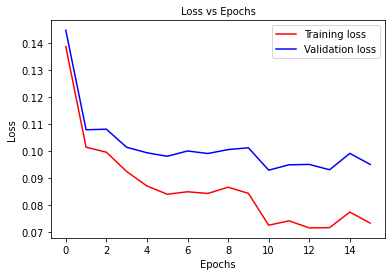

epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
training_acc,▁▅▅▆▆▇▇▇▇▇████▇█
training_loss,█▄▄▃▃▂▂▂▃▂▁▁▁▁▂▁
validation loss,█▃▃▂▂▂▂▂▂▂▁▁▁▁▂▁
validation_accuracy,▁▆▆▇▇▇▇▇▇▇█▇██▇█
epoch,16
training_acc,0.9028
training_loss,0.07345
validation loss,0.0952
validation_accuracy,0.87417


wandb: Agent Starting Run: fauv4rea with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_64_nh_6_af_identity_lr_0.01_init_Xavier_optim_nesterov_batch_32_l2_0_epochs_40
Stopping early at epoch 18. Best epoch: 13


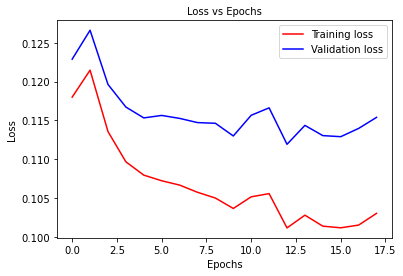

epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
training_acc,▂▁▄▅▆▆▆▆▇▇▇▇█▇████
training_loss,▇█▅▄▃▃▃▃▂▂▂▃▁▂▁▁▁▂
validation loss,▆█▅▃▃▃▃▂▂▂▃▃▁▂▂▁▂▃
validation_accuracy,▃▁▄▅▅▅▆▆▆▇▆▆█▇▇█▇▇
epoch,18
training_acc,0.86285
training_loss,0.10302
validation loss,0.11538
validation_accuracy,0.84517


wandb: Agent Starting Run: u9xnxtfz with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_64_nh_3_af_identity_lr_0.0001_init_random_optim_nadam_batch_128_l2_0_epochs_5


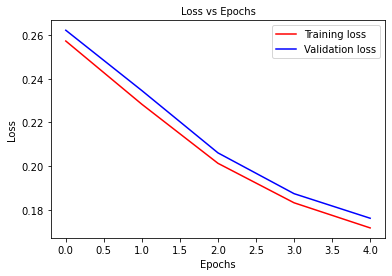

epoch,▁▃▅▆█
training_acc,▁▃▆██
training_loss,█▆▃▂▁
validation loss,█▆▃▂▁
validation_accuracy,▁▄▆██
epoch,5
training_acc,0.75235
training_loss,0.17172
validation loss,0.17614
validation_accuracy,0.74517


wandb: Agent Starting Run: 482eak3s with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_32_nh_3_af_identity_lr_0.0001_init_random_optim_rmsprop_batch_32_l2_0_epochs_5


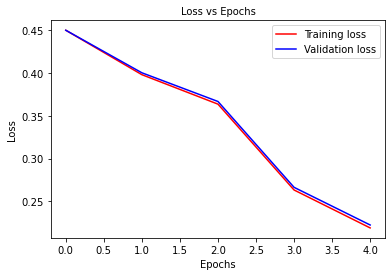

epoch,▁▃▅▆█
training_acc,▁▂▄▇█
training_loss,█▆▅▂▁
validation loss,█▆▅▂▁
validation_accuracy,▁▂▄▇█
epoch,5
training_acc,0.68724
training_loss,0.21903
validation loss,0.22245
validation_accuracy,0.68633


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x8937oop with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_64_nh_4_af_sigmoid_lr_0.001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_40
Stopping early at epoch 14. Best epoch: 9


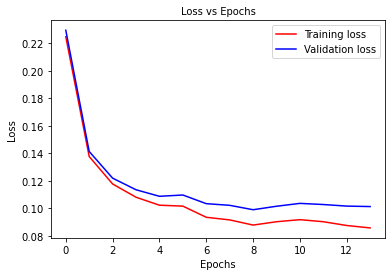

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
training_acc,▁▅▆▇▇▇████████
training_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁
validation loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▇▇▇▇████████
epoch,14
training_acc,0.8857
training_loss,0.08572
validation loss,0.10127
validation_accuracy,0.86567


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nwq2i936 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


nn_128_nh_3_af_tanh_lr_0.001_init_random_optim_sgd_batch_128_l2_0_epochs_40


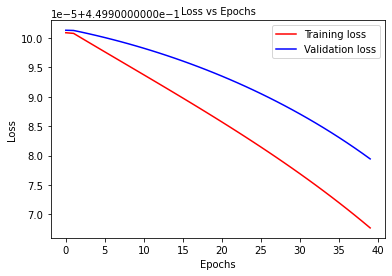

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▄▆█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
validation loss,██████▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁
validation_accuracy,▆▇█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
training_acc,0.10093
training_loss,0.44997
validation loss,0.44998
validation_accuracy,0.09167


wandb: Agent Starting Run: qyx73fsk with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


nn_64_nh_6_af_sigmoid_lr_0.001_init_random_optim_momentum_batch_128_l2_0_epochs_30
Stopping early at epoch 9. Best epoch: 4


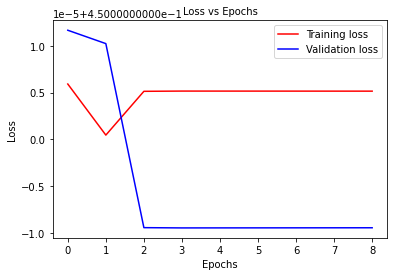

epoch,▁▂▃▄▅▅▆▇█
training_acc,▄█▁▁▁▁▁▁▁
training_loss,█▁▇▇▇▇▇▇▇
validation loss,██▁▁▁▁▁▁▁
validation_accuracy,▅▁███████
epoch,9
training_acc,0.09961
training_loss,0.45001
validation loss,0.44999
validation_accuracy,0.1035


wandb: Agent Starting Run: ja2xdwkh with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_128_nh_4_af_sigmoid_lr_0.0001_init_Xavier_optim_sgd_batch_256_l2_0_epochs_40


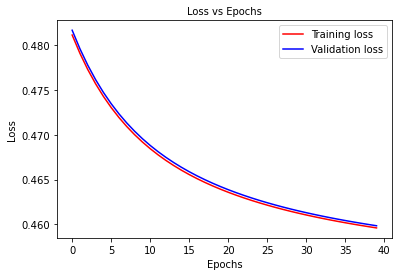

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,40
training_acc,0.10024
training_loss,0.4596
validation loss,0.45984
validation_accuracy,0.09783


wandb: Agent Starting Run: sborraod with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


nn_256_nh_5_af_relu_lr_0.01_init_random_optim_adam_batch_64_l2_0_epochs_40
Stopping early at epoch 7. Best epoch: 2


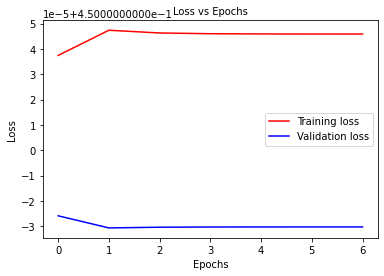

epoch,▁▂▃▅▆▇█
training_acc,▁▁▁▁▁▁▁
training_loss,▁█▇▇▇▇▇
validation loss,█▁▁▂▂▂▂
validation_accuracy,▁▁▁▁▁▁▁
epoch,7
training_acc,0.09961
training_loss,0.45005
validation loss,0.44997
validation_accuracy,0.1035


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h3x79buv with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum


nn_256_nh_5_af_relu_lr_0.001_init_random_optim_momentum_batch_32_l2_0_epochs_5


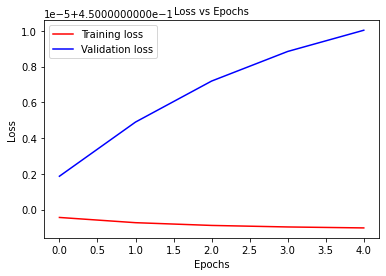

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▅▃▂▁
validation loss,▁▄▆▇█
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3gyaw3b8 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_256_nh_3_af_tanh_lr_0.0001_init_random_optim_nadam_batch_128_l2_0_epochs_30
Stopping early at epoch 20. Best epoch: 15


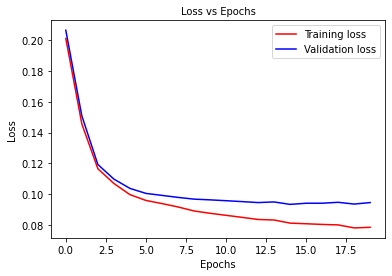

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▄▆▆▇▇▇▇▇▇██████████
training_loss,█▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▆▇▇▇▇█████████████
epoch,20
training_acc,0.89419
training_loss,0.07853
validation loss,0.09459
validation_accuracy,0.8725


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yysfyr76 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_128_nh_3_af_identity_lr_0.01_init_random_optim_rmsprop_batch_32_l2_0_epochs_40
Stopping early at epoch 6. Best epoch: 1


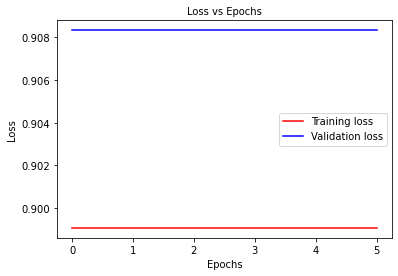

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁
validation loss,▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.89907
validation loss,0.90833
validation_accuracy,0.09167


wandb: Agent Starting Run: c4wy8zqj with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_256_nh_4_af_identity_lr_0.001_init_Xavier_optim_sgd_batch_32_l2_0_epochs_30


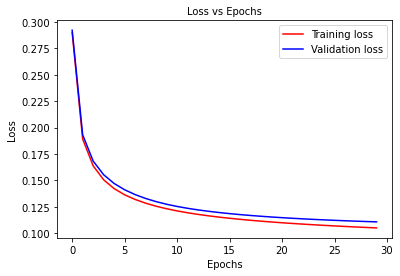

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▅▆▆▇▇▇▇▇▇▇▇██████████████████
training_loss,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▇▇▇▇▇▇▇███████████████████
epoch,30
training_acc,0.85872
training_loss,0.10494
validation loss,0.11068
validation_accuracy,0.8485


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zn3yv6jl with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_128_nh_5_af_identity_lr_0.001_init_random_optim_nadam_batch_64_l2_0_epochs_40
Stopping early at epoch 39. Best epoch: 34


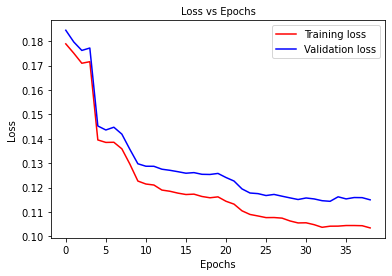

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▁▁▁▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████████
training_loss,██▇▇▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,██▇▇▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▂▂▅▅▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████████
epoch,39
training_acc,0.86169
training_loss,0.10345
validation loss,0.11497
validation_accuracy,0.84733


wandb: Agent Starting Run: e0logfea with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


nn_128_nh_5_af_relu_lr_0.01_init_random_optim_adam_batch_32_l2_0_epochs_30
Stopping early at epoch 6. Best epoch: 1


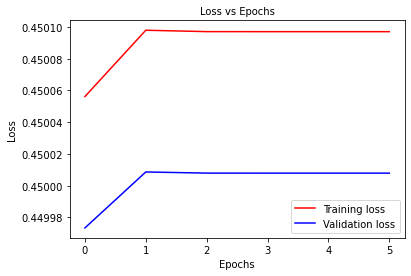

epoch,▁▂▄▅▇█
training_acc,▁█████
training_loss,▁█████
validation loss,▁█████
validation_accuracy,█▁▁▁▁▁
epoch,6
training_acc,0.09965
training_loss,0.4501
validation loss,0.45001
validation_accuracy,0.10317


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2i704iz9 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


nn_64_nh_3_af_tanh_lr_0.001_init_random_optim_momentum_batch_64_l2_0_epochs_30
Stopping early at epoch 6. Best epoch: 1


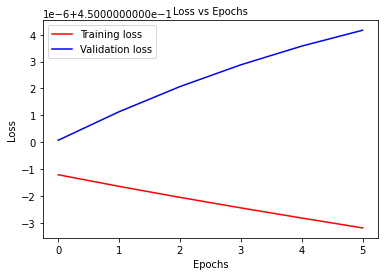

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▆▅▄▂▁
validation loss,▁▃▄▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Agent Starting Run: xydum17h with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum


nn_256_nh_4_af_sigmoid_lr_0.001_init_Xavier_optim_momentum_batch_32_l2_0_epochs_5


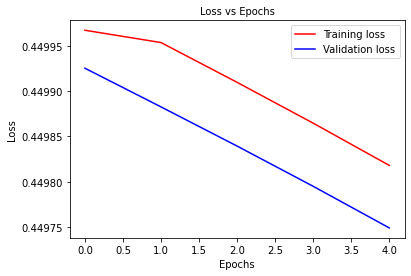

epoch,▁▃▅▆█
training_acc,▁▇███
training_loss,█▇▅▃▁
validation loss,█▆▅▃▁
validation_accuracy,▁▇███
epoch,5
training_acc,0.14517
training_loss,0.44982
validation loss,0.44975
validation_accuracy,0.15033


wandb: Agent Starting Run: 9d00paub with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_64_nh_4_af_relu_lr_0.001_init_Xavier_optim_sgd_batch_32_l2_0_epochs_40


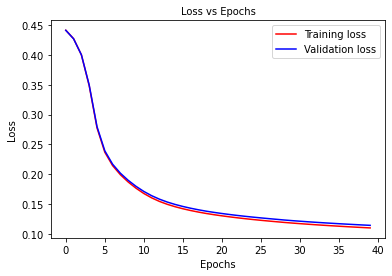

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▂▄▅▆▆▆▇▇▇▇▇▇▇██████████████████████████
training_loss,██▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,██▇▆▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▂▄▅▆▆▆▇▇▇▇▇▇▇██████████████████████████
epoch,40
training_acc,0.8507
training_loss,0.1099
validation loss,0.1142
validation_accuracy,0.84233


wandb: Agent Starting Run: c6m9ag6q with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_128_nh_4_af_tanh_lr_0.001_init_random_optim_rmsprop_batch_128_l2_0_epochs_20
Stopping early at epoch 17. Best epoch: 12


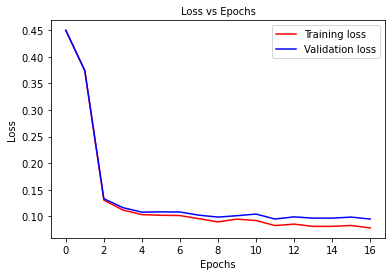

epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
training_acc,▁▂▇██████████████
training_loss,█▇▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▃▇██████████████
epoch,17
training_acc,0.89554
training_loss,0.07817
validation loss,0.09489
validation_accuracy,0.8735


wandb: Agent Starting Run: uk1of103 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: sgd


nn_128_nh_6_af_identity_lr_0.0001_init_random_optim_sgd_batch_64_l2_0_epochs_40
Stopping early at epoch 6. Best epoch: 1


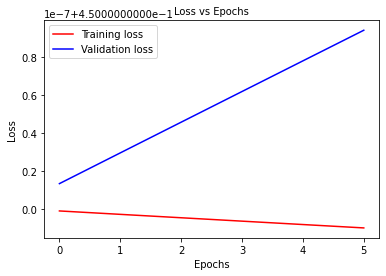

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁
validation loss,▁▁▃▃▆█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ie0ubo9p with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_128_nh_4_af_relu_lr_0.01_init_random_optim_sgd_batch_64_l2_0_epochs_5


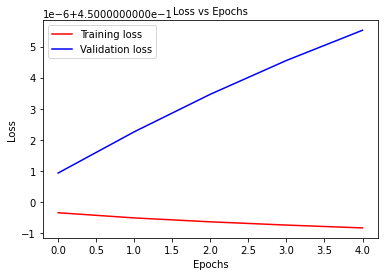

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▆▄▂▁
validation loss,▁▃▅▇█
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: 57zfesv2 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_32_nh_4_af_tanh_lr_0.01_init_Xavier_optim_sgd_batch_128_l2_0_epochs_20


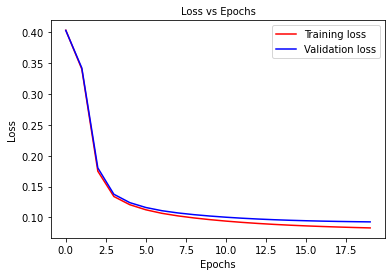

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▄▇▇▇▇██████████████
training_loss,█▇▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▇▇▇███████████████
epoch,20
training_acc,0.88869
training_loss,0.08288
validation loss,0.09267
validation_accuracy,0.8715


wandb: Agent Starting Run: ogl1l9t5 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


nn_128_nh_6_af_identity_lr_0.001_init_random_optim_rmsprop_batch_128_l2_0_epochs_20
Stopping early at epoch 8. Best epoch: 3


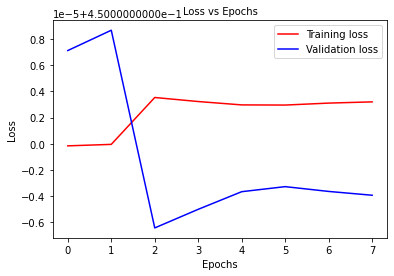

epoch,▁▂▃▄▅▆▇█
training_acc,██▁▁▁▁▁▁
training_loss,▁▁█▇▇▇▇▇
validation loss,▇█▁▂▂▂▂▂
validation_accuracy,▁▁██████
epoch,8
training_acc,0.09961
training_loss,0.45
validation loss,0.45
validation_accuracy,0.1035


wandb: Agent Starting Run: jidtkgmx with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum


nn_128_nh_4_af_tanh_lr_0.0001_init_Xavier_optim_momentum_batch_256_l2_0_epochs_40


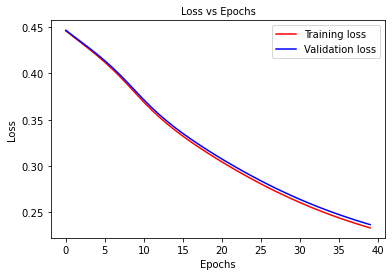

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▂▂▂▃▃▃▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████
training_loss,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation loss,███▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▂▂▂▃▃▃▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█████████████
epoch,40
training_acc,0.68728
training_loss,0.23334
validation loss,0.23687
validation_accuracy,0.67883


wandb: Agent Starting Run: o2raho6v with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_64_nh_6_af_sigmoid_lr_0.0001_init_Xavier_optim_nesterov_batch_256_l2_0_epochs_5


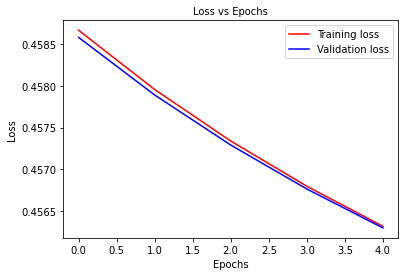

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▆▄▂▁
validation loss,█▆▄▂▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10019
training_loss,0.45632
validation loss,0.4563
validation_accuracy,0.09833


wandb: Agent Starting Run: bzzdird6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_64_nh_4_af_sigmoid_lr_0.001_init_Xavier_optim_sgd_batch_128_l2_0_epochs_15


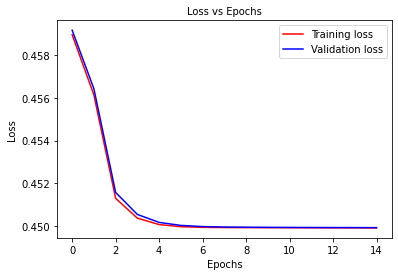

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▅▅▅▅█▁▅▆▆▆▆▆▆▆▆
training_loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▆▆▆▆█▂▁▂▂▂▂▂▂▂▂
epoch,15
training_acc,0.10154
training_loss,0.4499
validation loss,0.44991
validation_accuracy,0.0925


wandb: Agent Starting Run: ryuvtu0a with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam


nn_128_nh_4_af_relu_lr_0.01_init_Xavier_optim_adam_batch_64_l2_0_epochs_30
Stopping early at epoch 15. Best epoch: 10


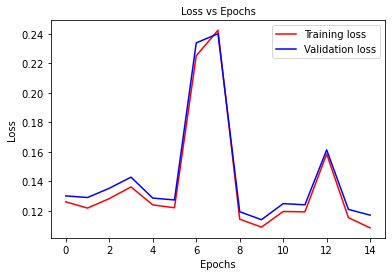

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▆▇▇▆▇▇▁▁▇█▇▇▅██
training_loss,▂▂▂▂▂▂▇█▁▁▂▂▄▁▁
validation loss,▂▂▂▃▂▂██▁▁▂▂▄▁▁
validation_accuracy,▇▇▇▆▇▇▁▂██▇█▆▇█
epoch,15
training_acc,0.8537
training_loss,0.10846
validation loss,0.1171
validation_accuracy,0.8395


wandb: Agent Starting Run: h1cbbxa6 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_256_nh_3_af_tanh_lr_0.0001_init_random_optim_nadam_batch_64_l2_0_epochs_30


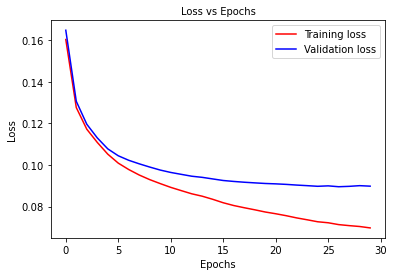

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████
training_loss,█▅▅▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▅▆▆▆▇▇▇▇▇▇██████████████████
epoch,30
training_acc,0.90663
training_loss,0.06969
validation loss,0.08979
validation_accuracy,0.87417


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 09jetet3 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_64_nh_3_af_identity_lr_0.001_init_random_optim_rmsprop_batch_256_l2_0_epochs_15


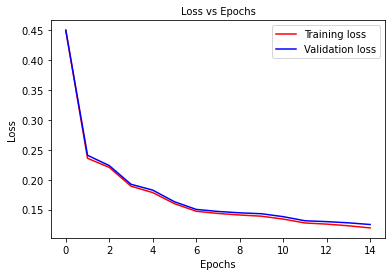

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▆▆▇▇▇█████████
training_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁
validation loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▆▇▇▇█████████
epoch,15
training_acc,0.83469
training_loss,0.11944
validation loss,0.12513
validation_accuracy,0.82733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x6h4kdz5 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_32_nh_4_af_identity_lr_0.001_init_Xavier_optim_sgd_batch_256_l2_0_epochs_30


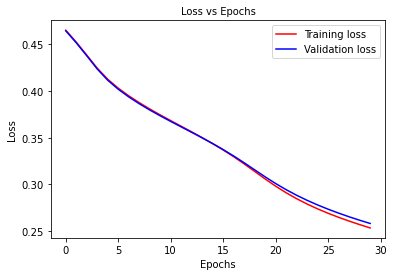

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▂▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇████████
training_loss,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁
validation loss,██▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
validation_accuracy,▁▂▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇████████
epoch,30
training_acc,0.64154
training_loss,0.25328
validation loss,0.25803
validation_accuracy,0.63683


wandb: Agent Starting Run: ci8zedq4 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


nn_128_nh_3_af_sigmoid_lr_0.0001_init_Xavier_optim_nesterov_batch_32_l2_0_epochs_20


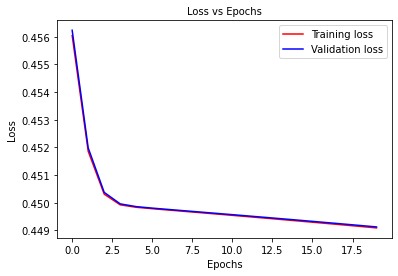

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▄▃▄▅▅▆▆▆▇▇▇▇▇█████
training_loss,█▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▂▁▃▃▄▅▅▆▆▇▇▇▇▇▇█████
epoch,20
training_acc,0.32715
training_loss,0.44909
validation loss,0.44913
validation_accuracy,0.31783


wandb: Agent Starting Run: t1wd1sr1 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum


nn_128_nh_4_af_relu_lr_0.001_init_random_optim_momentum_batch_32_l2_0_epochs_20
Stopping early at epoch 6. Best epoch: 1


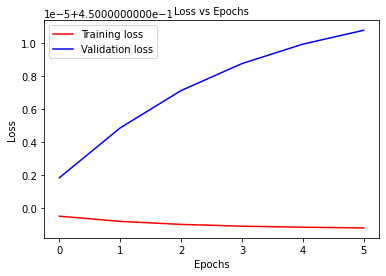

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▃▂▁▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: p4gxztds with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam


nn_128_nh_3_af_relu_lr_0.0001_init_Xavier_optim_adam_batch_256_l2_0_epochs_40


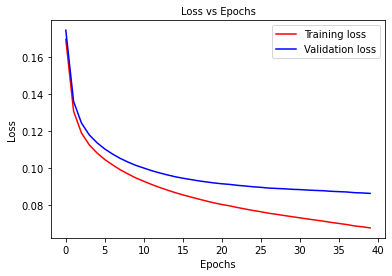

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▃▄▄▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
training_loss,█▅▅▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████
epoch,40
training_acc,0.9107
training_loss,0.06744
validation loss,0.08614
validation_accuracy,0.88233


wandb: Agent Starting Run: 800vxl87 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_32_nh_4_af_sigmoid_lr_0.01_init_random_optim_rmsprop_batch_64_l2_0_epochs_5


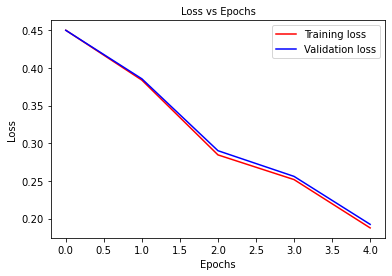

epoch,▁▃▅▆█
training_acc,▁▃▅▆█
training_loss,█▆▄▃▁
validation loss,█▆▄▃▁
validation_accuracy,▁▃▅▆█
epoch,5
training_acc,0.71628
training_loss,0.18755
validation loss,0.19228
validation_accuracy,0.70767


wandb: Agent Starting Run: i1u3fcuz with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


nn_32_nh_4_af_sigmoid_lr_0.0001_init_random_optim_nadam_batch_64_l2_0_epochs_30


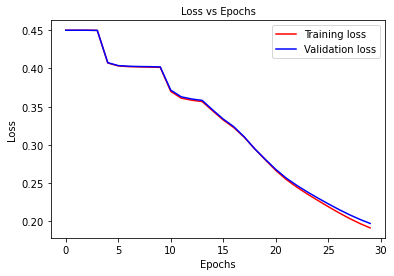

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▁▁▁▂▂▂▂▂▂▃▃▃▄▄▅▅▆▆▆▆▇▇███████
training_loss,████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
validation loss,████▇▇▇▇▇▇▆▆▆▅▅▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
validation_accuracy,▁▁▁▁▂▂▂▂▂▂▃▃▄▄▅▅▆▆▆▆▆▇▇███████
epoch,30
training_acc,0.72387
training_loss,0.19139
validation loss,0.19723
validation_accuracy,0.70633


wandb: Agent Starting Run: yrmzvw3y with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: rmsprop


nn_256_nh_6_af_sigmoid_lr_0.001_init_random_optim_rmsprop_batch_128_l2_0_epochs_40
Stopping early at epoch 8. Best epoch: 3


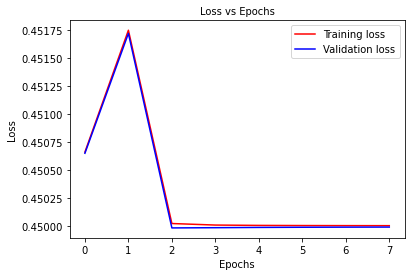

epoch,▁▂▃▄▅▆▇█
training_acc,▂▂▂█▁▁▁▁
training_loss,▄█▁▁▁▁▁▁
validation loss,▄█▁▁▁▁▁▁
validation_accuracy,▇▇▇▁████
epoch,8
training_acc,0.09961
training_loss,0.45001
validation loss,0.44999
validation_accuracy,0.1035


wandb: Agent Starting Run: ge0dkj0m with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


nn_128_nh_3_af_sigmoid_lr_0.001_init_Xavier_optim_momentum_batch_64_l2_0_epochs_15


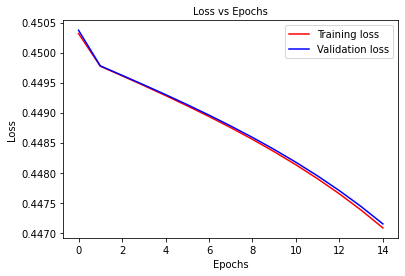

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▃▅▆▇████████▇▇
training_loss,█▇▆▆▆▅▅▅▄▄▃▃▂▂▁
validation loss,█▇▆▆▆▅▅▅▄▄▃▃▂▂▁
validation_accuracy,▁▃▅▇▇█████▇▇▇▇▇
epoch,15
training_acc,0.24657
training_loss,0.44708
validation loss,0.44715
validation_accuracy,0.238


wandb: Agent Starting Run: 1rhgfc8e with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_64_nh_3_af_relu_lr_0.0001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_15


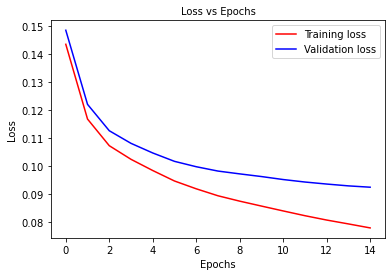

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▃▅▅▆▆▆▇▇▇▇▇███
training_loss,█▅▄▄▃▃▂▂▂▂▂▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▁▄▅▆▇▇▇▇▇██████
epoch,15
training_acc,0.89606
training_loss,0.07779
validation loss,0.09238
validation_accuracy,0.87067


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ns8jogyz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_32_nh_6_af_tanh_lr_0.01_init_random_optim_nesterov_batch_256_l2_0_epochs_40
Stopping early at epoch 6. Best epoch: 1


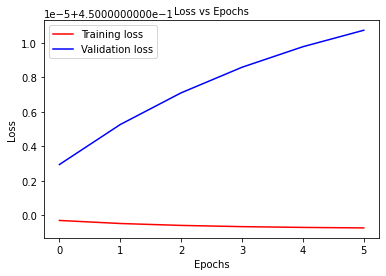

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▃▂▁▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: uazmgszz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum


nn_128_nh_5_af_sigmoid_lr_0.001_init_Xavier_optim_momentum_batch_256_l2_0_epochs_40
Stopping early at epoch 14. Best epoch: 9


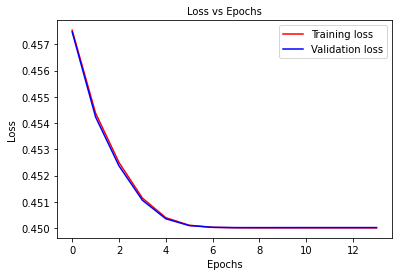

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
training_acc,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
training_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,14
training_acc,0.10093
training_loss,0.45001
validation loss,0.45002
validation_accuracy,0.09167


wandb: Agent Starting Run: krycs7j3 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: identity
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


nn_64_nh_4_af_identity_lr_0.0001_init_random_optim_nadam_batch_256_l2_0_epochs_20


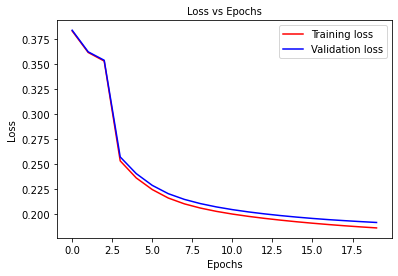

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▁▂▆▇▇▇▇████████████
training_loss,█▇▇▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation loss,█▇▇▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▂▆▇▇▇▇████████████
epoch,20
training_acc,0.7313
training_loss,0.18637
validation loss,0.19182
validation_accuracy,0.72067


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o34mae9j with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


nn_256_nh_3_af_relu_lr_0.001_init_random_optim_nesterov_batch_128_l2_0_epochs_30


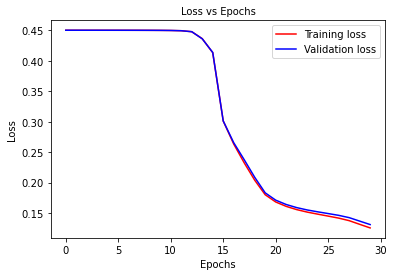

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▅▆▆▇▇▇▇████████
training_loss,██████████████▇▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁
validation loss,██████████████▇▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁
validation_accuracy,▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▅▆▆▇▇▇█████████
epoch,30
training_acc,0.82709
training_loss,0.12572
validation loss,0.13122
validation_accuracy,0.8185


wandb: Agent Starting Run: gi3c7lo8 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


nn_256_nh_4_af_sigmoid_lr_0.0001_init_Xavier_optim_nadam_batch_128_l2_0_epochs_40


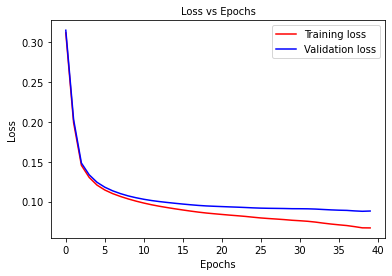

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████████
training_loss,█▅▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▇▇▇▇▇▇▇██████████████████████████████
epoch,40
training_acc,0.9117
training_loss,0.06693
validation loss,0.08814
validation_accuracy,0.88217


wandb: Agent Starting Run: vel5jbgs with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


nn_64_nh_6_af_relu_lr_0.0001_init_Xavier_optim_adam_batch_32_l2_0_epochs_5


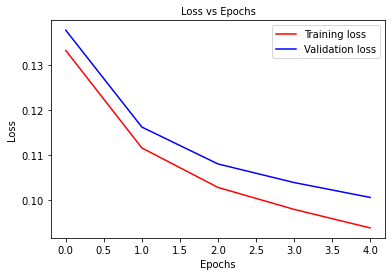

epoch,▁▃▅▆█
training_acc,▁▅▇▇█
training_loss,█▄▃▂▁
validation loss,█▄▂▂▁
validation_accuracy,▁▅▇██
epoch,5
training_acc,0.8732
training_loss,0.09374
validation loss,0.10051
validation_accuracy,0.86283


wandb: Agent Starting Run: rqog3frb with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


nn_128_nh_5_af_relu_lr_0.001_init_random_optim_rmsprop_batch_128_l2_0_epochs_30
Stopping early at epoch 13. Best epoch: 8


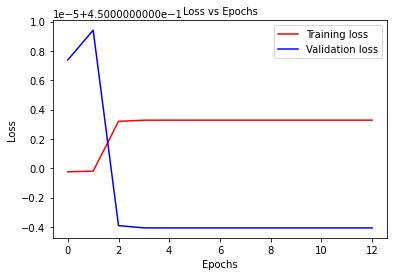

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
training_acc,██▁▁▁▁▁▁▁▁▁▁▁
training_loss,▁▁███████████
validation loss,▇█▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁███████████
epoch,13
training_acc,0.09961
training_loss,0.45
validation loss,0.45
validation_accuracy,0.1035


wandb: Agent Starting Run: zv1he472 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


nn_64_nh_3_af_tanh_lr_0.01_init_random_optim_momentum_batch_32_l2_0_epochs_15


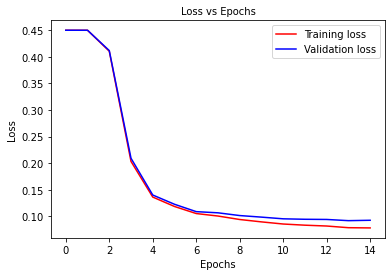

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▁▂▆▇▇█████████
training_loss,██▇▃▂▂▂▁▁▁▁▁▁▁▁
validation loss,██▇▃▂▂▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▂▆▇██████████
epoch,15
training_acc,0.8953
training_loss,0.0783
validation loss,0.09268
validation_accuracy,0.87333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3e8ef0tu with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: rmsprop


nn_128_nh_3_af_sigmoid_lr_0.0001_init_Xavier_optim_rmsprop_batch_32_l2_0_epochs_20


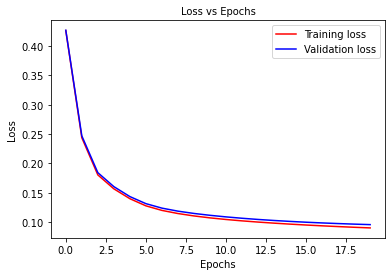

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▆▇▇▇▇██████████████
training_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▆▇▇▇▇██████████████
epoch,20
training_acc,0.87757
training_loss,0.08993
validation loss,0.09555
validation_accuracy,0.8685


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ln8y89tn with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: sgd


nn_64_nh_4_af_relu_lr_0.001_init_Xavier_optim_sgd_batch_32_l2_0_epochs_15


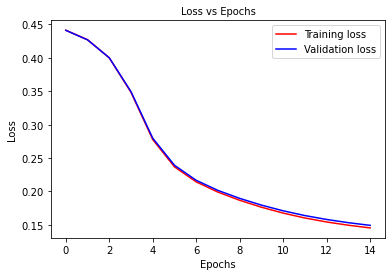

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▂▄▆▆▆▇▇▇██████
training_loss,██▇▆▄▃▃▂▂▂▂▁▁▁▁
validation loss,██▇▆▄▃▃▂▂▂▂▁▁▁▁
validation_accuracy,▁▂▄▆▆▆▇▇▇██████
epoch,15
training_acc,0.80519
training_loss,0.14546
validation loss,0.14928
validation_accuracy,0.79833


wandb: Agent Starting Run: t4e796nw with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: adam


nn_128_nh_4_af_sigmoid_lr_0.0001_init_Xavier_optim_adam_batch_64_l2_0_epochs_30


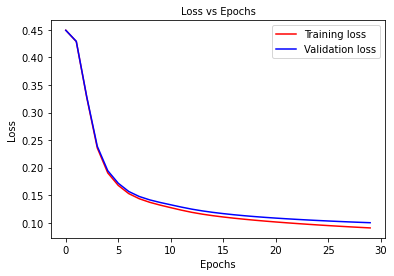

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▁▄▆▇▇▇▇▇▇▇███████████████████
training_loss,██▆▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,██▆▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▄▆▇▇▇▇▇▇▇███████████████████
epoch,30
training_acc,0.87826
training_loss,0.09064
validation loss,0.10008
validation_accuracy,0.8635


wandb: Agent Starting Run: caer3c84 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: momentum


nn_32_nh_5_af_sigmoid_lr_0.01_init_Xavier_optim_momentum_batch_128_l2_0_epochs_40


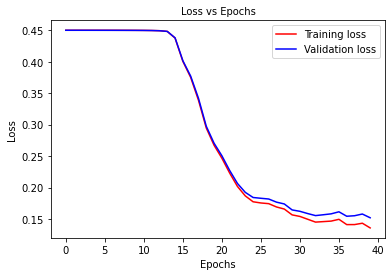

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▄▅▅▆▇▇▇▇▇▇▇████████████
training_loss,███████████████▇▆▆▅▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation loss,███████████████▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▃▄▅▅▆▇▇▇▇▇▇█████████████
epoch,40
training_acc,0.82511
training_loss,0.13591
validation loss,0.15204
validation_accuracy,0.802


wandb: Agent Starting Run: fx6kvy54 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


nn_64_nh_6_af_relu_lr_0.001_init_Xavier_optim_momentum_batch_32_l2_0_epochs_15


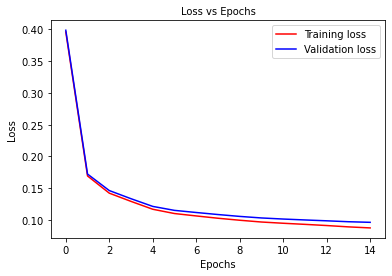

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▇▇▇███████████
training_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁
validation loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▇▇▇███████████
epoch,15
training_acc,0.88141
training_loss,0.08766
validation loss,0.09646
validation_accuracy,0.86717


wandb: Agent Starting Run: b2k9r9h8 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: nadam


nn_64_nh_4_af_relu_lr_0.01_init_Xavier_optim_nadam_batch_256_l2_0_epochs_15
Stopping early at epoch 10. Best epoch: 5


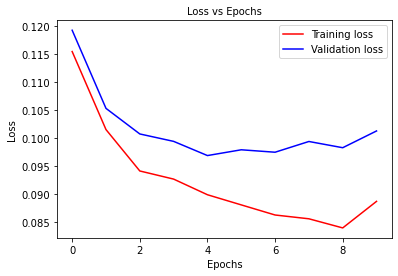

epoch,▁▂▃▃▄▅▆▆▇█
training_acc,▁▄▅▆▆▇▇██▇
training_loss,█▅▃▃▂▂▂▁▁▂
validation loss,█▄▂▂▁▁▁▂▁▂
validation_accuracy,▁▅▆▇▇▇██▇▇
epoch,10
training_acc,0.88093
training_loss,0.08867
validation loss,0.10125
validation_accuracy,0.86267


wandb: Agent Starting Run: ot4zbfkk with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: momentum


nn_64_nh_4_af_sigmoid_lr_0.0001_init_random_optim_momentum_batch_32_l2_0_epochs_5


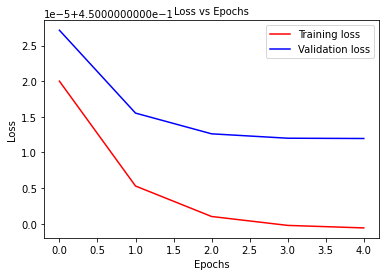

epoch,▁▃▅▆█
training_acc,▁▁▁██
training_loss,█▃▂▁▁
validation loss,█▃▁▁▁
validation_accuracy,███▁▁
epoch,5
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: r30ijgy2 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


nn_64_nh_5_af_identity_lr_0.001_init_random_optim_rmsprop_batch_32_l2_0_epochs_20
Stopping early at epoch 7. Best epoch: 2


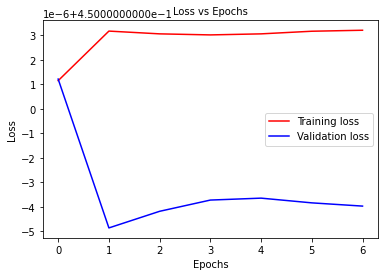

epoch,▁▂▃▅▆▇█
training_acc,█▁▁▁▁▁▁
training_loss,▁█▇▇▇██
validation loss,█▁▂▂▂▂▂
validation_accuracy,▁██████
epoch,7
training_acc,0.09961
training_loss,0.45
validation loss,0.45
validation_accuracy,0.1035


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tth5ze80 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nadam


nn_64_nh_5_af_sigmoid_lr_0.01_init_Xavier_optim_nadam_batch_64_l2_0_epochs_15
Stopping early at epoch 11. Best epoch: 6


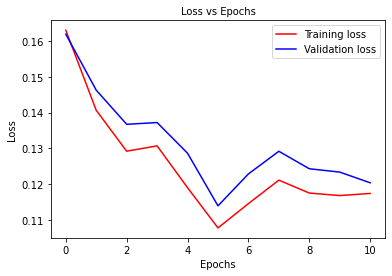

epoch,▁▂▂▃▄▅▅▆▇▇█
training_acc,▁▄▅▅▇█▇▅▆▇▇
training_loss,█▅▄▄▂▁▂▃▂▂▂
validation loss,█▆▄▄▃▁▂▃▃▂▂
validation_accuracy,▁▃▅▄▆█▇▅▆▇▇
epoch,11
training_acc,0.84122
training_loss,0.11744
validation loss,0.12041
validation_accuracy,0.83883


wandb: Agent Starting Run: dtpoosn4 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: sgd


nn_128_nh_3_af_relu_lr_0.001_init_random_optim_sgd_batch_128_l2_0_epochs_40
Stopping early at epoch 9. Best epoch: 4


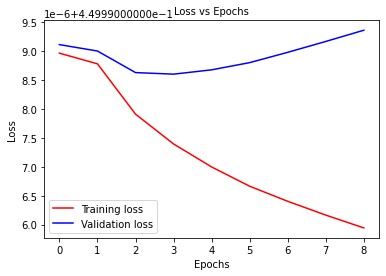

epoch,▁▂▃▄▅▅▆▇█
training_acc,██▁▁▁▁▁▁▁
training_loss,██▆▄▃▃▂▂▁
validation loss,▆▅▁▁▂▃▅▆█
validation_accuracy,██▁▁▁▁▁▁▁
epoch,9
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Agent Starting Run: gonlto2d with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: momentum


nn_32_nh_6_af_relu_lr_0.01_init_random_optim_momentum_batch_64_l2_0_epochs_5


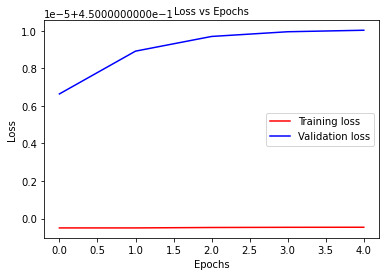

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,▁▁▁██
validation loss,▁▆▇██
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ozirh3i9 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 32
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: rmsprop


nn_32_nh_5_af_sigmoid_lr_0.0001_init_Xavier_optim_rmsprop_batch_128_l2_0_epochs_5


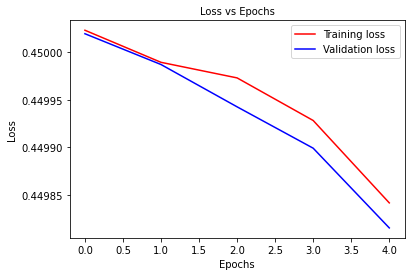

epoch,▁▃▅▆█
training_acc,▂▁▆██
training_loss,█▇▆▄▁
validation loss,█▇▅▄▁
validation_accuracy,▁▁▆██
epoch,5
training_acc,0.21694
training_loss,0.44984
validation loss,0.44982
validation_accuracy,0.22183


wandb: Agent Starting Run: e487m736 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


nn_256_nh_6_af_tanh_lr_0.0001_init_random_optim_adam_batch_256_l2_0_epochs_20
Stopping early at epoch 6. Best epoch: 1


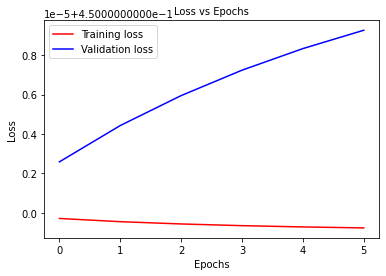

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▄▃▁▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: avay0qip with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_128_nh_3_af_sigmoid_lr_0.01_init_random_optim_nadam_batch_256_l2_0_epochs_20
Stopping early at epoch 6. Best epoch: 1


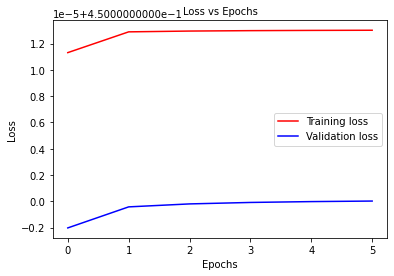

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁█████
validation loss,▁▆▇███
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.09961
training_loss,0.45001
validation loss,0.45
validation_accuracy,0.1035


wandb: Agent Starting Run: 9f6lj68d with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov


nn_64_nh_5_af_identity_lr_0.001_init_Xavier_optim_nesterov_batch_64_l2_0_epochs_30


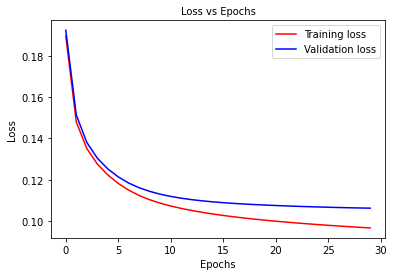

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
training_acc,▁▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇██████████████
training_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▁▅▆▆▇▇▇▇▇▇████████████████████
epoch,30
training_acc,0.8705
training_loss,0.0967
validation loss,0.10626
validation_accuracy,0.8555


wandb: Agent Starting Run: 20hdli3u with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: adam


nn_128_nh_6_af_relu_lr_0.001_init_Xavier_optim_adam_batch_128_l2_0_epochs_20


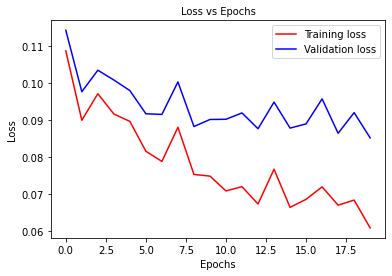

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▄▃▄▄▅▅▄▆▆▇▇▇▆▇▇▇▇▇█
training_loss,█▅▆▆▅▄▄▅▃▃▂▃▂▃▂▂▃▂▂▁
validation loss,█▄▅▅▄▃▃▅▂▂▂▃▂▃▂▂▄▁▃▁
validation_accuracy,▁▅▄▄▄▆▇▅▇▇▇▆▇▅▇▆▆▇▇█
epoch,20
training_acc,0.91804
training_loss,0.06096
validation loss,0.08522
validation_accuracy,0.88733


wandb: Agent Starting Run: 49dkkiok with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 30
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov


nn_256_nh_5_af_sigmoid_lr_0.01_init_Xavier_optim_nesterov_batch_128_l2_0_epochs_30
Stopping early at epoch 7. Best epoch: 2


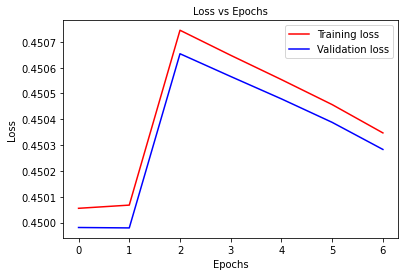

epoch,▁▂▃▅▆▇█
training_acc,▁▂█▂▂▂▂
training_loss,▁▁█▇▆▅▄
validation loss,▁▁█▇▆▅▄
validation_accuracy,█▇▁▇▇▇▇
epoch,7
training_acc,0.09965
training_loss,0.45035
validation loss,0.45028
validation_accuracy,0.10317


wandb: Agent Starting Run: 2y20hj5k with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nadam


nn_64_nh_3_af_sigmoid_lr_0.0001_init_random_optim_nadam_batch_32_l2_0_epochs_5


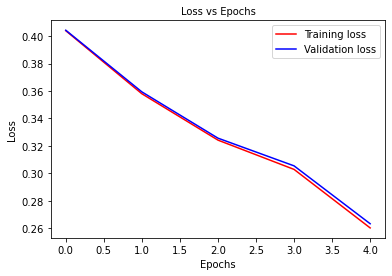

epoch,▁▃▅▆█
training_acc,▁▄▅▆█
training_loss,█▆▄▃▁
validation loss,█▆▄▃▁
validation_accuracy,▁▄▅▆█
epoch,5
training_acc,0.59372
training_loss,0.26022
validation loss,0.26326
validation_accuracy,0.58367


wandb: Agent Starting Run: adn9nkcl with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: relu
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: momentum


nn_256_nh_3_af_relu_lr_0.001_init_random_optim_momentum_batch_128_l2_0_epochs_40


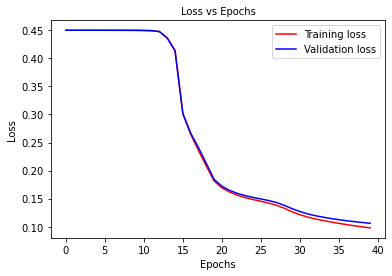

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
training_acc,▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▄▅▆▆▇▇▇▇▇▇▇▇▇████████████
training_loss,██████████████▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation loss,██████████████▇▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
validation_accuracy,▂▁▁▁▁▁▁▁▁▁▂▂▂▂▃▅▅▆▆▇▇▇▇▇▇▇▇▇████████████
epoch,40
training_acc,0.86893
training_loss,0.09784
validation loss,0.10606
validation_accuracy,0.8575


wandb: Agent Starting Run: ifxb6wk0 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.001
wandb: 	neurons_per_layer: 64
wandb: 	num_hidden_layers: 4
wandb: 	optimizer: rmsprop


nn_64_nh_4_af_relu_lr_0.001_init_Xavier_optim_rmsprop_batch_256_l2_0_epochs_20


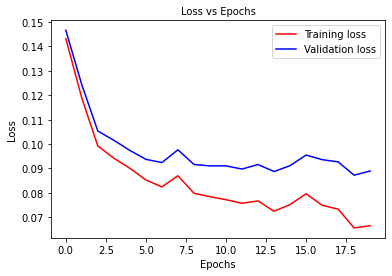

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
training_acc,▁▃▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
training_loss,█▆▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁
validation loss,█▅▃▃▂▂▂▂▂▁▁▁▂▁▁▂▂▂▁▁
validation_accuracy,▁▃▆▆▇▇▇▆▇▇▇█▇█▇▇▇▇██
epoch,20
training_acc,0.90928
training_loss,0.06657
validation loss,0.08899
validation_accuracy,0.8795


wandb: Agent Starting Run: jt68rzhw with config:
wandb: 	L2_lamb: 0
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: adam


nn_256_nh_5_af_relu_lr_0.0001_init_random_optim_adam_batch_64_l2_0_epochs_30
Stopping early at epoch 6. Best epoch: 1


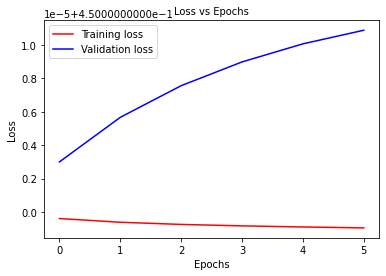

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,█▅▄▃▁▁
validation loss,▁▃▅▆▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09167


wandb: Agent Starting Run: pdugeigy with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: identity
wandb: 	batch_size: 64
wandb: 	epochs: 15
wandb: 	init: Xavier
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 256
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: nesterov


nn_256_nh_3_af_identity_lr_0.0001_init_Xavier_optim_nesterov_batch_64_l2_0_epochs_15


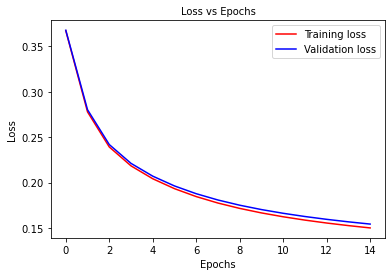

epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
training_acc,▁▅▅▆▆▇▇▇▇██████
training_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
validation loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁
validation_accuracy,▁▄▅▆▆▇▇▇███████
epoch,15
training_acc,0.8037
training_loss,0.14997
validation loss,0.1542
validation_accuracy,0.80017


wandb: Agent Starting Run: tit599be with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: relu
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init: Xavier
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nadam


nn_128_nh_6_af_relu_lr_0.01_init_Xavier_optim_nadam_batch_256_l2_0_epochs_20
Stopping early at epoch 6. Best epoch: 1


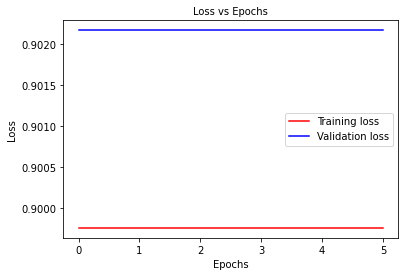

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁
validation loss,▁▁▁▁▁▁
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10024
training_loss,0.89976
validation loss,0.90217
validation_accuracy,0.09783


wandb: Agent Starting Run: 6bxlyukt with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 6
wandb: 	optimizer: nesterov


nn_128_nh_6_af_sigmoid_lr_0.0001_init_random_optim_nesterov_batch_64_l2_0_epochs_5


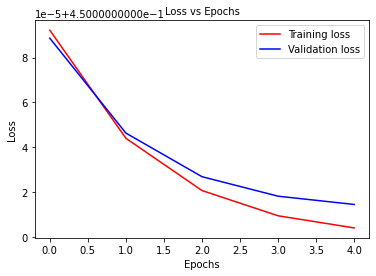

epoch,▁▃▅▆█
training_acc,▁▁▁▁▁
training_loss,█▄▂▁▁
validation loss,█▄▂▁▁
validation_accuracy,▁▁▁▁▁
epoch,5
training_acc,0.10024
training_loss,0.45
validation loss,0.45001
validation_accuracy,0.09783


wandb: Agent Starting Run: serm6h97 with config:
wandb: 	L2_lamb: 0.05
wandb: 	activation_function: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init: random
wandb: 	learning_rate: 0.0001
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 5
wandb: 	optimizer: nesterov


nn_128_nh_5_af_tanh_lr_0.0001_init_random_optim_nesterov_batch_256_l2_0_epochs_40
Stopping early at epoch 6. Best epoch: 1


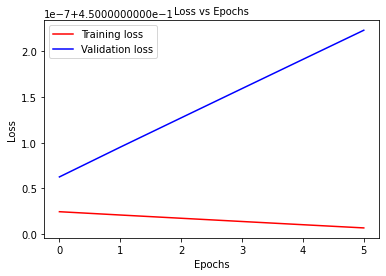

epoch,▁▂▄▅▇█
training_acc,▁▁▁▁▁▁
training_loss,▁▁▁▁▁▁
validation loss,▁▂▄▅▇█
validation_accuracy,▁▁▁▁▁▁
epoch,6
training_acc,0.10093
training_loss,0.45
validation loss,0.45
validation_accuracy,0.09167


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qpx4xhyb with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 30
wandb: 	init: random
wandb: 	learning_rate: 0.01
wandb: 	neurons_per_layer: 128
wandb: 	num_hidden_layers: 3
wandb: 	optimizer: adam


nn_128_nh_3_af_sigmoid_lr_0.01_init_random_optim_adam_batch_64_l2_0_epochs_30
Stopping early at epoch 24. Best epoch: 19


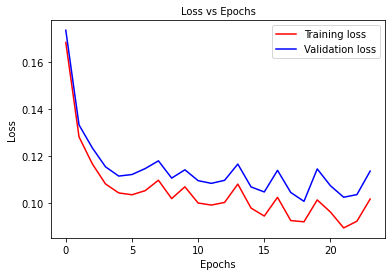

epoch,▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
training_acc,▁▄▅▆▆▇▆▆▇▆▇▇▇▆▇▇▇██▇▇██▇
training_loss,█▄▃▃▂▂▂▃▂▃▂▂▂▃▂▁▂▁▁▂▂▁▁▂
validation loss,█▄▃▂▂▂▂▃▂▂▂▂▂▃▂▁▂▁▁▂▂▁▁▂
validation_accuracy,▁▅▅▆▆▇▆▆▇▇▇▇▇▆▇▇▆██▇▇██▇
epoch,24
training_acc,0.86698
training_loss,0.10181
validation loss,0.11367
validation_accuracy,0.85283


In [10]:

sweep_config = {
  "name": "MSE-Finals-1",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "neurons_per_layer": {
            "values": [32, 64, 128, 256]
        },
         "num_hidden_layers": {
            "values": [3, 4, 5, 6]
        },
        "activation_function": {
            "values": ["sigmoid", "relu", "tanh","identity"]
        },
        "learning_rate": {
            "values": [0.01, 0.001, 0.0001]
        },
        "init": {
            "values": ["Xavier", "random"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nesterov", "adam", "nadam", "rmsprop"]
        },
        "batch_size": {
            "values": [32,64,128,256]
        },
        "L2_lamb": {
            "values": [0, 0.05, 0.5]
        },
        "epochs": {
            "values": [5, 15, 20, 30, 40]
        } 
    }
}

sweep_id = wandb.sweep(sweep_config,  entity="shashwat_mm19b053", project="Assignment-1")
wandb.agent(sweep_id, NN_wandb_sweep, count=150)